<a href="https://colab.research.google.com/github/kode-git/FER-Visual-Transformers/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In this notebook, we will balance dataset and prepares data for the training phase.

## Install Dependencies and Import Libraries

In [51]:
!pip3 install Pillow

In [52]:
# classic libraries for collections.
import pandas as pd
import numpy as np

# utility library.
import random, time, copy, sys, shutil
import os
# plot libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# libraries for image processing.
import os, cv2, glob, imageio, sys
from PIL import Image

# warning library for service warnings.
import warnings

# ImageDataGenerator from keras library.
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Image Worker Implementation


ImageWorker provides some useful functions:
- Format Converter: For resize and move an image from *source_path* to *dest_path* filtered for *format_img*
- List Classes: Listing the classes and put them in an array to manipulate the subfolders for class functions divisions.
- Counter Samples per Class: Given a *dataset_path*, return a dictionary with counters of images classified by subfolders for plot or data visualization pourposes. 
- Counter Samples: Given a *dataset_path*, return a counter of images in the tree.
- Extension Converter: Convert an image format for every image in a specified path
- Counter Files Extension: Given a *path*, return the counter of image in the directory with a specific *format*
- Navigate Path: Counter every file in a subtree

In [53]:
class ImageWorker():
    """
    Image Worker class for Data Integration.
    This class manages images data, size and format.
    """
    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_path, dest_path, resize=(224,224)):
        """
        Move an image from source_path to dest_path.
        Images selected follow format_img.
        There is a default resize of (224,244).
        """
        count = 0
        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, resize, interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(dest_path + "resized_on_" + source_path + "_" + str(count) + "."+ format_img, resized)
            count += 1

    def list_classes(self, dataset_path):
        """
        List the classes of a dataset.
        """
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs


    def counter_samples_on_class(self, dataset_path):
      """
      Counts samples of classes.
      Each class has its own counter.
      Return a dictionary with (class, counter) pair.
      """
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes


    def counter_samples(self, dataset_path):
      """
      Counts total samples of a dataset.
      """
      a = self.counter_samples_on_class(dataset_path)
      counter = 0
      for el in a.keys():
        counter += a[el]
      return counter


    def extension_converter(self, path, format_source, format_result, dest_path):   
      """
      Convert a file from format_source to format_result.
      The file is loaded from path and the result is stored to dest_path.
      """
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """
      Counts samples in path based on format input.
      """
      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      

    def navigate_path(self, path):    
      """
      Navigate in the path and counts every file
      """
      count = 0
      for dir in os.listdir(path):
          if os.path.isfile(os.path.join(path, dir)):
              count += 1
      return count

In [54]:
# define Image Worker instance
iw = ImageWorker()

## Common utilities


We implemented some logic and reusable functions useful for the data analysis or data manipulation phases. These functions carry out support routines for ImageWorker's class. They are:
- Min, Max and Mean: According to values or set of values passed as parameter.
- Plot Dataset: Function for plot image's dataset and color values according to the mean of classes cardinalities.
- Channel Distribution: Analyze images and return counters of images for different channels dimension.

In [55]:
def mean(values):
  """
  Calculates the mean in values.
  """
  if len(values) <= 0:
    return 0
  else:
    sum = 0
    for el in values:
      sum += el
    return int(sum / len(values))

def min(val):
  """
  Calculates the minimum in val.
  """
  min = sys.maxsize
  for el in val.keys():
    if val[el] < min:
      min = val[el]
  return min


def max(val):
  """
  Calculates the maximum in val.
  """
  max = sys.minsize
  for el in val.keys():
    if val[el] > max:
      max = val[el]
  return max


def plot_dataset(dataset_path, title=""):
  """
  Plot the dataset and color bars.
  Color depends on the lower bound and upper bound.
  The mean value is the congiuntion between lower and upper bound.
  """
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  y = [class_ for class_ in classes]
  
  colors = []
  x_cap = mean(x)

  # colors identify when the elements are greater or lesser than the mean values.
  for el in x:
    if el < x_cap:
      colors.append("#BC3434")
    else:
      colors.append("#49A131")
  ax.bar(y, x, color=colors)
  plt.title(title)
  plt.show()

### Original Dataset

In [56]:
# specifics of AVFER.
num_classes = 8
data_vision = []
base_directory = "./Vision+/*"
sets = iw.list_classes(base_directory)
i = 0

# display the subset division.
print('Division of Vision+: ')
for subset in sets:
  data_vision.append('./Vision+/' + subset + '/*')
  print(data_vision[i])
  i = i + 1
# counts of the subsets samples and total number.
vision_tot = 0
i = 0
total = 0
for i in range(3):
  base_directory = data_vision[i][:len(data_vision[i])-1]
  counter_folder = 0
  for cl in os.listdir(base_directory):
    for fl in os.listdir(base_directory + cl + "/"):
      counter_folder += 1
  print(f'Elements in {data_vision[i][:len(data_vision[i])-1]} are {counter_folder}')
  total += counter_folder
print("Total elements in the dataset is", total)

Division of Vision+: 
./Vision+/test/*
./Vision+/train/*
./Vision+/val/*
Elements in ./Vision+/test/ are 8719
Elements in ./Vision+/train/ are 36868
Elements in ./Vision+/val/ are 20323
Total elements in the dataset is 65910


In [57]:
data_vision

['./Vision+/test/*', './Vision+/train/*', './Vision+/val/*']

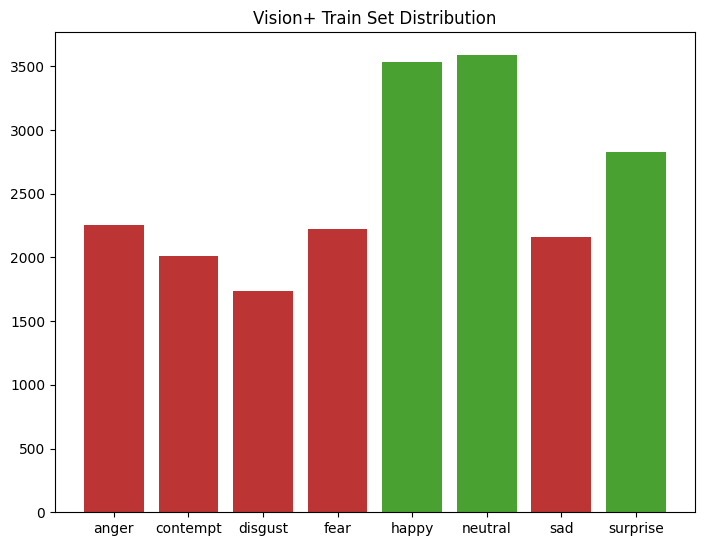

In [58]:
plot_dataset(data_vision[2], "Vision+ Train Set Distribution")

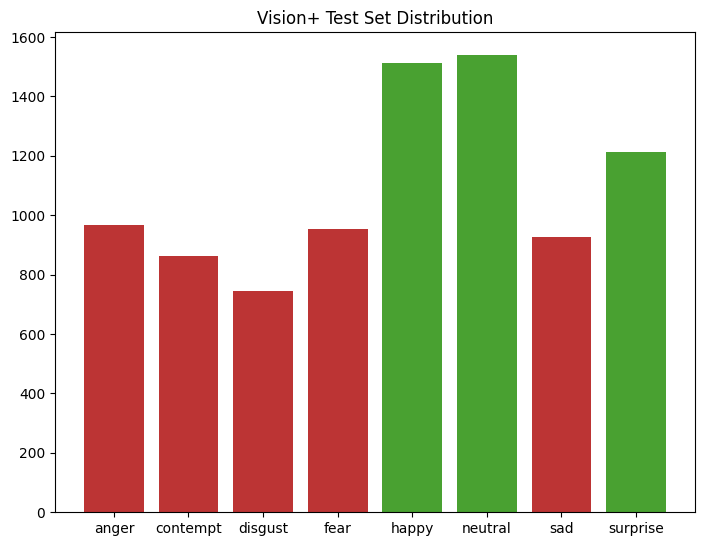

In [59]:
plot_dataset(data_vision[0], "Vision+ Test Set Distribution")

In [60]:
plot_dataset(data_vision[3], "Vision+ Validation Set Distribution")

IndexError: list index out of range

## Data Balancing

AVFER contains AffectNet in the validation and testing set and FER-2013 and CK+48 in the training set. We need to balance it remains only a small amount of samples in the val/test sets and put the rest in the training set. We need to balance every class in the testing and validation set before put the residual samples in the training folder.

In [61]:
!mkdir ".\Vision+\tmp"

In [62]:
# main variables.
basedir = "./Vision+/"
types = ['val', 'test', 'train']
ref = [str(basedir  + types[i] + "/*") for i in range(len(types))]
total = 0
for el in ref:
  total += iw.counter_samples(el)

# Splitting ratio 100 :-> 80/20 (train + val /test) and 80 :-> 85/15 (train/val).
train_ratio = 85
val_ratio = 15
test_ratio = 15

# Splitting distribution.
val_amount = int((((total * train_ratio) / 100) * val_ratio / 100))
test_amount = int((total * test_ratio)/ 100)
train_amount = int(total - (val_amount + test_amount))
print('Goal of samples in the validation set:', val_amount) 
print('Goal of samples in the test set:', test_amount) 
print('Goal of samples in the training set:', train_amount) 

Goal of samples in the validation set: 8403
Goal of samples in the test set: 9886
Goal of samples in the training set: 47621


In [63]:
print('Amount of samples for augmented training set divided by classes:', int(train_amount / 8))
print('Amount of samples for validation set divided by classes:', int(val_amount / 8))
print('Amount of samples for testing set divided by classes:', int(test_amount / 8))

Amount of samples for augmented training set divided by classes: 5952
Amount of samples for validation set divided by classes: 1050
Amount of samples for testing set divided by classes: 1235


### Validation Balancing

In [64]:
val = ref[0]
# validation balancing.
val = ref[0]
min = sys.maxsize
countcl = iw.counter_samples_on_class(val)
for el in countcl.keys():
  if countcl[el] < min:
    min = countcl[el]
print(min)
# controls on the minimum number.
if min < (val_amount / 8):
  print('Error, the amount of samples for the validation set can\'t be reduce to minimum values')

# updating residuals counters.
classes = iw.list_classes(val)
residual = {}
for cl in classes:
  residual[cl] = countcl[cl] - (val_amount / 8) 
  #os.mkdir(basedir + "tmp/" + cl + "/")
    
print('-'*40)
# check validation preconditions.
print('Verify the correct amount for validation...')
err = False
for cl in classes:
  if residual[cl] < 0:
    print(f'Error, the residual amount put class {cl} to illegal value')
    err = True

if not err:
  print('Splitting possible.')

1733
----------------------------------------
Verify the correct amount for validation...
Splitting possible.


In [65]:
# splittig training and validation set according to the proportion previously calculated.
basedir = "./Vision+/"
types = ['val', 'test', 'train']
valdir = basedir + types[0] + "/"
testdir = basedir + types[1] + "/"
for cl in classes:
  c = 0
  for fl in glob.glob(valdir + cl + "/*"):
    if c < int(residual[cl]):
      c += 1
      shutil.copyfile(fl, os.path.join(testdir + cl, os.path.basename(fl)))
      os.remove(os.path.join(valdir + cl, os.path.basename(fl)))
    else:
      break

### Test Balancing

In [66]:
print(ref[1])

./Vision+/test/*


In [73]:
test = ref[1]
min = sys.maxsize
countcl = iw.counter_samples_on_class(test)
for el in countcl.keys():
  if countcl[el] < min:
    min = countcl[el]
print(countcl)
print(test_amount/8)    
# controls on the minimum number.
if min < (test_amount / 8):
  print('Error, the amount of samples for the validation set can\'t be reduce to minimum values')

# updating residuals counters.
classes = iw.list_classes(test)
residual = {}
for cl in classes:
  residual[cl] = countcl[cl] - (test_amount / 8) 
  #os.mkdir(basedir + "tmp/" + cl + "/")
    
print('-'*40)
# check validation preconditions.
print('Verify the correct amount for test...')
err = False
for cl in classes:
  if residual[cl] < 0:
    print(f'Error, the residual amount put class {cl} to illegal value')
    err = True

if not err:
  print('Splitting possible.')

{'angry': 2167, 'contempt': 1236, 'disgust': 1236, 'fear': 1236, 'happy': 1236, 'neutral': 1236, 'sad': 1236, 'surprise': 1236}
1235.75
----------------------------------------
Verify the correct amount for test...
Splitting possible.


In [74]:
# splittig training and validation set according to the proportion previously calculated.
basedir = "./Vision+/"
types = ['val', 'test', 'train']
testdir = basedir + types[1] + "/"
traindir = basedir + types[2] + "/"
for cl in classes:
  c = 0
  for fl in glob.glob(testdir + cl + "/*"):
    if c < int(residual[cl]):
      c += 1
      shutil.copyfile(fl, os.path.join(traindir + cl, os.path.basename(fl)))
      os.remove(os.path.join(testdir + cl, os.path.basename(fl)))
    else:
      break

### Dataset Plot

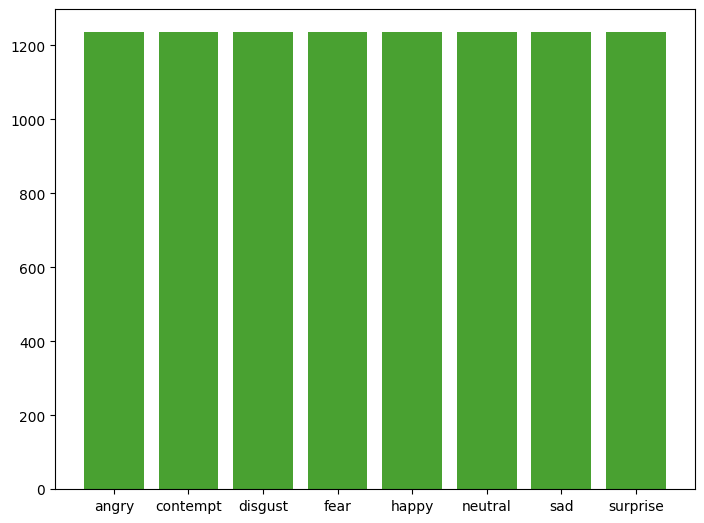

In [75]:
# plot testing set.
testdir = "./Vision+/test"
plot_dataset(testdir + "/*")

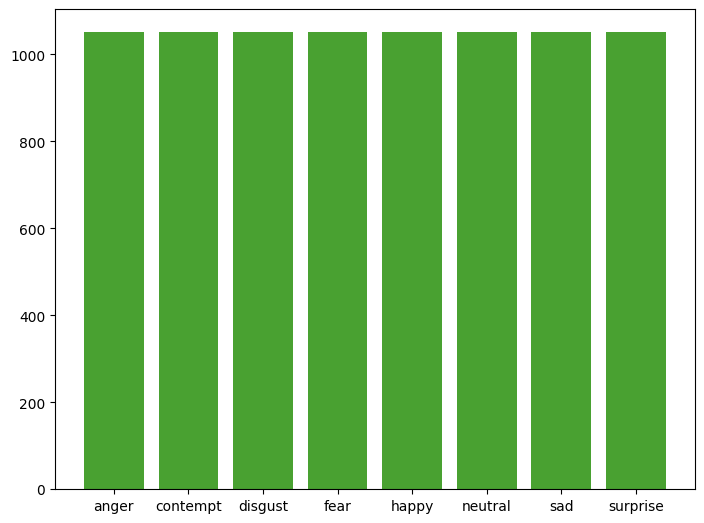

In [76]:
# plot testing set.
testdir = "./Vision+/val"
plot_dataset(testdir + "/*")

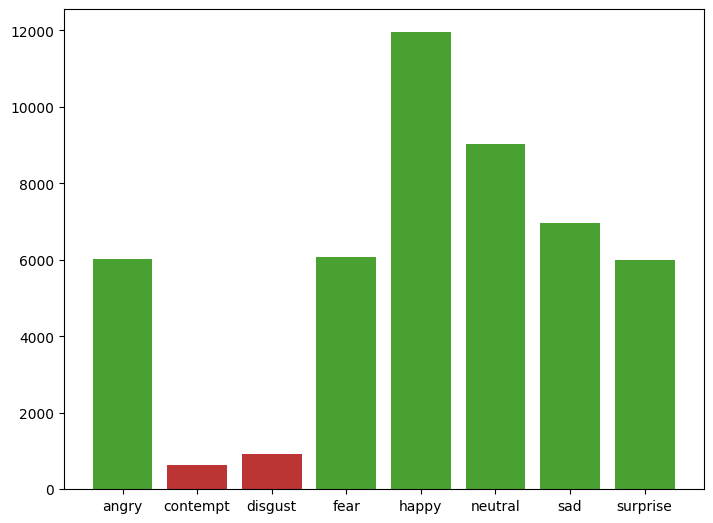

In [77]:
# plot testing set.
testdir = "./Vision+/train"
plot_dataset(testdir + "/*")

Unfortunately, the amount of data for the training set is unbalanced. So, we need to preprocess data of this subfolder using data augmentation and possible integration with additional data, especially for the disgust and contempt classes.

## Convert Formats

### Grayscale2RGB

Vision+ includes some CK+ samples in PNG format, and several images are in grayscale with one channel. To prevent the side effects of artificial coloring and ensure the integrity of the images, we will simply adjust the number of channels and convert the pixel values to RGB, without altering other aspects of the images.

The grayscale images in our dataset primarily consist of FER-2013 and CK+48 samples. These images use a single byte per pixel, which encodes the brightness value ranging from 0 to 255. For processing that requires RGB format (3 channels), we need to convert each grayscale pixel into an RGB pixel. During this conversion, we replicate the single-byte grayscale value across all three color channels (red, green, and blue). This approach ensures that each RGB pixel retains the original grayscale brightness, effectively preserving the gray tone of the image without altering the pixel values.

In [78]:
# Define the base path of the dataset
path = "./Vision+/"

# Initialize counters for grayscale (1 channel) and RGB (3 channels) images
total = [0, 0]  # total[0] for grayscale, total[1] for RGB

# Loop over directories in the base path
for directory in glob.glob(path + "*"):
    # Loop over subdirectories within each directory
    for class_dir in glob.glob(directory + "/*"):
        counter = [0, 0]  # Local counter for the current subdirectory
        # Loop over image files within each class subdirectory
        for file in glob.glob(class_dir + "/*"):
            # Read the image file without forcing it to grayscale
            image = cv2.imread(file)

            if image is not None and len(image.shape) == 2:  # Image is in grayscale
                counter[0] += 1
                # Convert grayscale image to RGB by replicating grayscale values across three channels
                image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                # Save the RGB image back to the same file
                cv2.imwrite(file, image_rgb)
            elif image is not None and len(image.shape) == 3 and image.shape[2] == 3:  # Image is already in RGB
                counter[1] += 1
            else:
                print(f"Unexpected image format or error reading image at {file}")

        # Update the total counters with the counts from the current subdirectory
        total = [total[i] + counter[i] for i in range(2)]

# Print the total number of grayscale and RGB images processed
print('Total number of images in grayscale and RGB, respectively:', total)

Total number of images in grayscale and RGB, respectively: [0, 65910]


### png2jpg

In [79]:
import cv2
import glob
import os

path = "./Vision+/"
# Loop over directories in the base path
for directory in glob.glob(path + "*"):
    # Loop over subdirectories within each directory
    for class_dir in glob.glob(directory + "/*"):
        # Loop over image files within each class subdirectory
        for fl in glob.glob(class_dir + "/*"):
            # Check if the file has a .png extension
            if fl.endswith('.png'):
                # Read the PNG image
                image = cv2.imread(fl)
                # Define the new filename with a .jpg extension
                new_filename = fl[:-4] + ".jpg"
                # Convert and save the image in JPEG format
                cv2.imwrite(new_filename, image)
                # Optionally delete the original PNG file
                os.remove(fl)
                print(f"Converted {fl} to {new_filename}")


Converted ./Vision+\test\happy\resized_ffhq_348.png to ./Vision+\test\happy\resized_ffhq_348.jpg
Converted ./Vision+\test\happy\resized_ffhq_3480.png to ./Vision+\test\happy\resized_ffhq_3480.jpg
Converted ./Vision+\test\happy\resized_ffhq_3481.png to ./Vision+\test\happy\resized_ffhq_3481.jpg
Converted ./Vision+\test\happy\resized_ffhq_3482.png to ./Vision+\test\happy\resized_ffhq_3482.jpg
Converted ./Vision+\test\happy\resized_ffhq_3483.png to ./Vision+\test\happy\resized_ffhq_3483.jpg
Converted ./Vision+\test\happy\resized_ffhq_3484.png to ./Vision+\test\happy\resized_ffhq_3484.jpg
Converted ./Vision+\test\happy\resized_ffhq_3485.png to ./Vision+\test\happy\resized_ffhq_3485.jpg
Converted ./Vision+\test\happy\resized_ffhq_3486.png to ./Vision+\test\happy\resized_ffhq_3486.jpg
Converted ./Vision+\test\happy\resized_ffhq_3487.png to ./Vision+\test\happy\resized_ffhq_3487.jpg
Converted ./Vision+\test\happy\resized_ffhq_3488.png to ./Vision+\test\happy\resized_ffhq_3488.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_3598.png to ./Vision+\test\happy\resized_ffhq_3598.jpg
Converted ./Vision+\test\happy\resized_ffhq_3599.png to ./Vision+\test\happy\resized_ffhq_3599.jpg
Converted ./Vision+\test\happy\resized_ffhq_36.png to ./Vision+\test\happy\resized_ffhq_36.jpg
Converted ./Vision+\test\happy\resized_ffhq_360.png to ./Vision+\test\happy\resized_ffhq_360.jpg
Converted ./Vision+\test\happy\resized_ffhq_3600.png to ./Vision+\test\happy\resized_ffhq_3600.jpg
Converted ./Vision+\test\happy\resized_ffhq_3601.png to ./Vision+\test\happy\resized_ffhq_3601.jpg
Converted ./Vision+\test\happy\resized_ffhq_3602.png to ./Vision+\test\happy\resized_ffhq_3602.jpg
Converted ./Vision+\test\happy\resized_ffhq_3603.png to ./Vision+\test\happy\resized_ffhq_3603.jpg
Converted ./Vision+\test\happy\resized_ffhq_3604.png to ./Vision+\test\happy\resized_ffhq_3604.jpg
Converted ./Vision+\test\happy\resized_ffhq_3605.png to ./Vision+\test\happy\resized_ffhq_3605.jpg
Converted ./Visi

Converted ./Vision+\test\happy\resized_ffhq_3685.png to ./Vision+\test\happy\resized_ffhq_3685.jpg
Converted ./Vision+\test\happy\resized_ffhq_3686.png to ./Vision+\test\happy\resized_ffhq_3686.jpg
Converted ./Vision+\test\happy\resized_ffhq_3687.png to ./Vision+\test\happy\resized_ffhq_3687.jpg
Converted ./Vision+\test\happy\resized_ffhq_3688.png to ./Vision+\test\happy\resized_ffhq_3688.jpg
Converted ./Vision+\test\happy\resized_ffhq_3689.png to ./Vision+\test\happy\resized_ffhq_3689.jpg
Converted ./Vision+\test\happy\resized_ffhq_369.png to ./Vision+\test\happy\resized_ffhq_369.jpg
Converted ./Vision+\test\happy\resized_ffhq_3690.png to ./Vision+\test\happy\resized_ffhq_3690.jpg
Converted ./Vision+\test\happy\resized_ffhq_3691.png to ./Vision+\test\happy\resized_ffhq_3691.jpg
Converted ./Vision+\test\happy\resized_ffhq_3692.png to ./Vision+\test\happy\resized_ffhq_3692.jpg
Converted ./Vision+\test\happy\resized_ffhq_3693.png to ./Vision+\test\happy\resized_ffhq_3693.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_3803.png to ./Vision+\test\happy\resized_ffhq_3803.jpg
Converted ./Vision+\test\happy\resized_ffhq_3804.png to ./Vision+\test\happy\resized_ffhq_3804.jpg
Converted ./Vision+\test\happy\resized_ffhq_3805.png to ./Vision+\test\happy\resized_ffhq_3805.jpg
Converted ./Vision+\test\happy\resized_ffhq_3806.png to ./Vision+\test\happy\resized_ffhq_3806.jpg
Converted ./Vision+\test\happy\resized_ffhq_3807.png to ./Vision+\test\happy\resized_ffhq_3807.jpg
Converted ./Vision+\test\happy\resized_ffhq_3808.png to ./Vision+\test\happy\resized_ffhq_3808.jpg
Converted ./Vision+\test\happy\resized_ffhq_3809.png to ./Vision+\test\happy\resized_ffhq_3809.jpg
Converted ./Vision+\test\happy\resized_ffhq_381.png to ./Vision+\test\happy\resized_ffhq_381.jpg
Converted ./Vision+\test\happy\resized_ffhq_3810.png to ./Vision+\test\happy\resized_ffhq_3810.jpg
Converted ./Vision+\test\happy\resized_ffhq_3811.png to ./Vision+\test\happy\resized_ffhq_3811.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_3885.png to ./Vision+\test\happy\resized_ffhq_3885.jpg
Converted ./Vision+\test\happy\resized_ffhq_3886.png to ./Vision+\test\happy\resized_ffhq_3886.jpg
Converted ./Vision+\test\happy\resized_ffhq_3887.png to ./Vision+\test\happy\resized_ffhq_3887.jpg
Converted ./Vision+\test\happy\resized_ffhq_3888.png to ./Vision+\test\happy\resized_ffhq_3888.jpg
Converted ./Vision+\test\happy\resized_ffhq_3889.png to ./Vision+\test\happy\resized_ffhq_3889.jpg
Converted ./Vision+\test\happy\resized_ffhq_389.png to ./Vision+\test\happy\resized_ffhq_389.jpg
Converted ./Vision+\test\happy\resized_ffhq_3890.png to ./Vision+\test\happy\resized_ffhq_3890.jpg
Converted ./Vision+\test\happy\resized_ffhq_3891.png to ./Vision+\test\happy\resized_ffhq_3891.jpg
Converted ./Vision+\test\happy\resized_ffhq_3892.png to ./Vision+\test\happy\resized_ffhq_3892.jpg
Converted ./Vision+\test\happy\resized_ffhq_3893.png to ./Vision+\test\happy\resized_ffhq_3893.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_400.png to ./Vision+\test\happy\resized_ffhq_400.jpg
Converted ./Vision+\test\happy\resized_ffhq_4000.png to ./Vision+\test\happy\resized_ffhq_4000.jpg
Converted ./Vision+\test\happy\resized_ffhq_4001.png to ./Vision+\test\happy\resized_ffhq_4001.jpg
Converted ./Vision+\test\happy\resized_ffhq_4002.png to ./Vision+\test\happy\resized_ffhq_4002.jpg
Converted ./Vision+\test\happy\resized_ffhq_4003.png to ./Vision+\test\happy\resized_ffhq_4003.jpg
Converted ./Vision+\test\happy\resized_ffhq_4004.png to ./Vision+\test\happy\resized_ffhq_4004.jpg
Converted ./Vision+\test\happy\resized_ffhq_4005.png to ./Vision+\test\happy\resized_ffhq_4005.jpg
Converted ./Vision+\test\happy\resized_ffhq_4006.png to ./Vision+\test\happy\resized_ffhq_4006.jpg
Converted ./Vision+\test\happy\resized_ffhq_4007.png to ./Vision+\test\happy\resized_ffhq_4007.jpg
Converted ./Vision+\test\happy\resized_ffhq_4008.png to ./Vision+\test\happy\resized_ffhq_4008.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_4086.png to ./Vision+\test\happy\resized_ffhq_4086.jpg
Converted ./Vision+\test\happy\resized_ffhq_4087.png to ./Vision+\test\happy\resized_ffhq_4087.jpg
Converted ./Vision+\test\happy\resized_ffhq_4088.png to ./Vision+\test\happy\resized_ffhq_4088.jpg
Converted ./Vision+\test\happy\resized_ffhq_4089.png to ./Vision+\test\happy\resized_ffhq_4089.jpg
Converted ./Vision+\test\happy\resized_ffhq_409.png to ./Vision+\test\happy\resized_ffhq_409.jpg
Converted ./Vision+\test\happy\resized_ffhq_4090.png to ./Vision+\test\happy\resized_ffhq_4090.jpg
Converted ./Vision+\test\happy\resized_ffhq_4091.png to ./Vision+\test\happy\resized_ffhq_4091.jpg
Converted ./Vision+\test\happy\resized_ffhq_4092.png to ./Vision+\test\happy\resized_ffhq_4092.jpg
Converted ./Vision+\test\happy\resized_ffhq_4093.png to ./Vision+\test\happy\resized_ffhq_4093.jpg
Converted ./Vision+\test\happy\resized_ffhq_4094.png to ./Vision+\test\happy\resized_ffhq_4094.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_4203.png to ./Vision+\test\happy\resized_ffhq_4203.jpg
Converted ./Vision+\test\happy\resized_ffhq_4206.png to ./Vision+\test\happy\resized_ffhq_4206.jpg
Converted ./Vision+\test\happy\resized_ffhq_4209.png to ./Vision+\test\happy\resized_ffhq_4209.jpg
Converted ./Vision+\test\happy\resized_ffhq_4213.png to ./Vision+\test\happy\resized_ffhq_4213.jpg
Converted ./Vision+\test\happy\resized_ffhq_4215.png to ./Vision+\test\happy\resized_ffhq_4215.jpg
Converted ./Vision+\test\happy\resized_ffhq_4220.png to ./Vision+\test\happy\resized_ffhq_4220.jpg
Converted ./Vision+\test\happy\resized_ffhq_4221.png to ./Vision+\test\happy\resized_ffhq_4221.jpg
Converted ./Vision+\test\happy\resized_ffhq_4223.png to ./Vision+\test\happy\resized_ffhq_4223.jpg
Converted ./Vision+\test\happy\resized_ffhq_4228.png to ./Vision+\test\happy\resized_ffhq_4228.jpg
Converted ./Vision+\test\happy\resized_ffhq_4230.png to ./Vision+\test\happy\resized_ffhq_4230.jpg
Converted 

Converted ./Vision+\test\happy\resized_ffhq_4537.png to ./Vision+\test\happy\resized_ffhq_4537.jpg
Converted ./Vision+\test\happy\resized_ffhq_4538.png to ./Vision+\test\happy\resized_ffhq_4538.jpg
Converted ./Vision+\test\happy\resized_ffhq_4542.png to ./Vision+\test\happy\resized_ffhq_4542.jpg
Converted ./Vision+\test\happy\resized_ffhq_455.png to ./Vision+\test\happy\resized_ffhq_455.jpg
Converted ./Vision+\test\happy\resized_ffhq_4550.png to ./Vision+\test\happy\resized_ffhq_4550.jpg
Converted ./Vision+\test\happy\resized_ffhq_4555.png to ./Vision+\test\happy\resized_ffhq_4555.jpg
Converted ./Vision+\test\happy\resized_ffhq_4563.png to ./Vision+\test\happy\resized_ffhq_4563.jpg
Converted ./Vision+\test\happy\resized_ffhq_4566.png to ./Vision+\test\happy\resized_ffhq_4566.jpg
Converted ./Vision+\test\happy\resized_ffhq_4569.png to ./Vision+\test\happy\resized_ffhq_4569.jpg
Converted ./Vision+\test\happy\resized_ffhq_4571.png to ./Vision+\test\happy\resized_ffhq_4571.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_4867.png to ./Vision+\test\happy\resized_ffhq_4867.jpg
Converted ./Vision+\test\happy\resized_ffhq_4869.png to ./Vision+\test\happy\resized_ffhq_4869.jpg
Converted ./Vision+\test\happy\resized_ffhq_4871.png to ./Vision+\test\happy\resized_ffhq_4871.jpg
Converted ./Vision+\test\happy\resized_ffhq_4872.png to ./Vision+\test\happy\resized_ffhq_4872.jpg
Converted ./Vision+\test\happy\resized_ffhq_488.png to ./Vision+\test\happy\resized_ffhq_488.jpg
Converted ./Vision+\test\happy\resized_ffhq_4885.png to ./Vision+\test\happy\resized_ffhq_4885.jpg
Converted ./Vision+\test\happy\resized_ffhq_4886.png to ./Vision+\test\happy\resized_ffhq_4886.jpg
Converted ./Vision+\test\happy\resized_ffhq_4892.png to ./Vision+\test\happy\resized_ffhq_4892.jpg
Converted ./Vision+\test\happy\resized_ffhq_4898.png to ./Vision+\test\happy\resized_ffhq_4898.jpg
Converted ./Vision+\test\happy\resized_ffhq_4902.png to ./Vision+\test\happy\resized_ffhq_4902.jpg
Converted ./

Converted ./Vision+\test\happy\resized_ffhq_662.png to ./Vision+\test\happy\resized_ffhq_662.jpg
Converted ./Vision+\test\happy\resized_ffhq_668.png to ./Vision+\test\happy\resized_ffhq_668.jpg
Converted ./Vision+\test\happy\resized_ffhq_67.png to ./Vision+\test\happy\resized_ffhq_67.jpg
Converted ./Vision+\test\happy\resized_ffhq_671.png to ./Vision+\test\happy\resized_ffhq_671.jpg
Converted ./Vision+\test\happy\resized_ffhq_672.png to ./Vision+\test\happy\resized_ffhq_672.jpg
Converted ./Vision+\test\happy\resized_ffhq_676.png to ./Vision+\test\happy\resized_ffhq_676.jpg
Converted ./Vision+\test\happy\resized_ffhq_680.png to ./Vision+\test\happy\resized_ffhq_680.jpg
Converted ./Vision+\test\happy\resized_ffhq_683.png to ./Vision+\test\happy\resized_ffhq_683.jpg
Converted ./Vision+\test\happy\resized_ffhq_684.png to ./Vision+\test\happy\resized_ffhq_684.jpg
Converted ./Vision+\test\happy\resized_ffhq_692.png to ./Vision+\test\happy\resized_ffhq_692.jpg
Converted ./Vision+\test\happy\r

Converted ./Vision+\test\neutral\resized_ffhq_4152.png to ./Vision+\test\neutral\resized_ffhq_4152.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4153.png to ./Vision+\test\neutral\resized_ffhq_4153.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4154.png to ./Vision+\test\neutral\resized_ffhq_4154.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4155.png to ./Vision+\test\neutral\resized_ffhq_4155.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4156.png to ./Vision+\test\neutral\resized_ffhq_4156.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4157.png to ./Vision+\test\neutral\resized_ffhq_4157.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4158.png to ./Vision+\test\neutral\resized_ffhq_4158.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4159.png to ./Vision+\test\neutral\resized_ffhq_4159.jpg
Converted ./Vision+\test\neutral\resized_ffhq_416.png to ./Vision+\test\neutral\resized_ffhq_416.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4160.png to ./Vision+\test\ne

Converted ./Vision+\test\neutral\resized_ffhq_4228.png to ./Vision+\test\neutral\resized_ffhq_4228.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4229.png to ./Vision+\test\neutral\resized_ffhq_4229.jpg
Converted ./Vision+\test\neutral\resized_ffhq_423.png to ./Vision+\test\neutral\resized_ffhq_423.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4230.png to ./Vision+\test\neutral\resized_ffhq_4230.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4231.png to ./Vision+\test\neutral\resized_ffhq_4231.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4232.png to ./Vision+\test\neutral\resized_ffhq_4232.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4233.png to ./Vision+\test\neutral\resized_ffhq_4233.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4234.png to ./Vision+\test\neutral\resized_ffhq_4234.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4235.png to ./Vision+\test\neutral\resized_ffhq_4235.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4236.png to ./Vision+\test\ne

Converted ./Vision+\test\neutral\resized_ffhq_4343.png to ./Vision+\test\neutral\resized_ffhq_4343.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4344.png to ./Vision+\test\neutral\resized_ffhq_4344.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4345.png to ./Vision+\test\neutral\resized_ffhq_4345.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4346.png to ./Vision+\test\neutral\resized_ffhq_4346.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4347.png to ./Vision+\test\neutral\resized_ffhq_4347.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4348.png to ./Vision+\test\neutral\resized_ffhq_4348.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4349.png to ./Vision+\test\neutral\resized_ffhq_4349.jpg
Converted ./Vision+\test\neutral\resized_ffhq_435.png to ./Vision+\test\neutral\resized_ffhq_435.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4350.png to ./Vision+\test\neutral\resized_ffhq_4350.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4351.png to ./Vision+\test\ne

Converted ./Vision+\test\neutral\resized_ffhq_4415.png to ./Vision+\test\neutral\resized_ffhq_4415.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4416.png to ./Vision+\test\neutral\resized_ffhq_4416.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4417.png to ./Vision+\test\neutral\resized_ffhq_4417.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4418.png to ./Vision+\test\neutral\resized_ffhq_4418.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4419.png to ./Vision+\test\neutral\resized_ffhq_4419.jpg
Converted ./Vision+\test\neutral\resized_ffhq_442.png to ./Vision+\test\neutral\resized_ffhq_442.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4420.png to ./Vision+\test\neutral\resized_ffhq_4420.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4421.png to ./Vision+\test\neutral\resized_ffhq_4421.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4422.png to ./Vision+\test\neutral\resized_ffhq_4422.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4423.png to ./Vision+\test\ne

Converted ./Vision+\test\neutral\resized_ffhq_4540.png to ./Vision+\test\neutral\resized_ffhq_4540.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4541.png to ./Vision+\test\neutral\resized_ffhq_4541.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4542.png to ./Vision+\test\neutral\resized_ffhq_4542.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4543.png to ./Vision+\test\neutral\resized_ffhq_4543.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4544.png to ./Vision+\test\neutral\resized_ffhq_4544.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4545.png to ./Vision+\test\neutral\resized_ffhq_4545.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4546.png to ./Vision+\test\neutral\resized_ffhq_4546.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4547.png to ./Vision+\test\neutral\resized_ffhq_4547.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4548.png to ./Vision+\test\neutral\resized_ffhq_4548.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4549.png to ./Vision+\test\

Converted ./Vision+\test\neutral\resized_ffhq_4670.png to ./Vision+\test\neutral\resized_ffhq_4670.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4671.png to ./Vision+\test\neutral\resized_ffhq_4671.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4672.png to ./Vision+\test\neutral\resized_ffhq_4672.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4673.png to ./Vision+\test\neutral\resized_ffhq_4673.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4674.png to ./Vision+\test\neutral\resized_ffhq_4674.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4675.png to ./Vision+\test\neutral\resized_ffhq_4675.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4676.png to ./Vision+\test\neutral\resized_ffhq_4676.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4677.png to ./Vision+\test\neutral\resized_ffhq_4677.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4678.png to ./Vision+\test\neutral\resized_ffhq_4678.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4679.png to ./Vision+\test\

Converted ./Vision+\test\neutral\resized_ffhq_4800.png to ./Vision+\test\neutral\resized_ffhq_4800.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4801.png to ./Vision+\test\neutral\resized_ffhq_4801.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4802.png to ./Vision+\test\neutral\resized_ffhq_4802.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4803.png to ./Vision+\test\neutral\resized_ffhq_4803.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4804.png to ./Vision+\test\neutral\resized_ffhq_4804.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4805.png to ./Vision+\test\neutral\resized_ffhq_4805.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4806.png to ./Vision+\test\neutral\resized_ffhq_4806.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4807.png to ./Vision+\test\neutral\resized_ffhq_4807.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4808.png to ./Vision+\test\neutral\resized_ffhq_4808.jpg
Converted ./Vision+\test\neutral\resized_ffhq_4809.png to ./Vision+\test\

Converted ./Vision+\test\neutral\resized_ffhq_5080.png to ./Vision+\test\neutral\resized_ffhq_5080.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5085.png to ./Vision+\test\neutral\resized_ffhq_5085.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5091.png to ./Vision+\test\neutral\resized_ffhq_5091.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5092.png to ./Vision+\test\neutral\resized_ffhq_5092.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5094.png to ./Vision+\test\neutral\resized_ffhq_5094.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5095.png to ./Vision+\test\neutral\resized_ffhq_5095.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5096.png to ./Vision+\test\neutral\resized_ffhq_5096.jpg
Converted ./Vision+\test\neutral\resized_ffhq_51.png to ./Vision+\test\neutral\resized_ffhq_51.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5101.png to ./Vision+\test\neutral\resized_ffhq_5101.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5102.png to ./Vision+\test\neut

Converted ./Vision+\test\neutral\resized_ffhq_5509.png to ./Vision+\test\neutral\resized_ffhq_5509.jpg
Converted ./Vision+\test\neutral\resized_ffhq_551.png to ./Vision+\test\neutral\resized_ffhq_551.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5510.png to ./Vision+\test\neutral\resized_ffhq_5510.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5511.png to ./Vision+\test\neutral\resized_ffhq_5511.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5513.png to ./Vision+\test\neutral\resized_ffhq_5513.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5514.png to ./Vision+\test\neutral\resized_ffhq_5514.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5520.png to ./Vision+\test\neutral\resized_ffhq_5520.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5521.png to ./Vision+\test\neutral\resized_ffhq_5521.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5522.png to ./Vision+\test\neutral\resized_ffhq_5522.jpg
Converted ./Vision+\test\neutral\resized_ffhq_5525.png to ./Vision+\test\ne

Converted ./Vision+\test\neutral\resized_ffhq_858.png to ./Vision+\test\neutral\resized_ffhq_858.jpg
Converted ./Vision+\test\neutral\resized_ffhq_86.png to ./Vision+\test\neutral\resized_ffhq_86.jpg
Converted ./Vision+\test\neutral\resized_ffhq_860.png to ./Vision+\test\neutral\resized_ffhq_860.jpg
Converted ./Vision+\test\neutral\resized_ffhq_862.png to ./Vision+\test\neutral\resized_ffhq_862.jpg
Converted ./Vision+\test\neutral\resized_ffhq_864.png to ./Vision+\test\neutral\resized_ffhq_864.jpg
Converted ./Vision+\test\neutral\resized_ffhq_865.png to ./Vision+\test\neutral\resized_ffhq_865.jpg
Converted ./Vision+\test\neutral\resized_ffhq_870.png to ./Vision+\test\neutral\resized_ffhq_870.jpg
Converted ./Vision+\test\neutral\resized_ffhq_872.png to ./Vision+\test\neutral\resized_ffhq_872.jpg
Converted ./Vision+\test\neutral\resized_ffhq_877.png to ./Vision+\test\neutral\resized_ffhq_877.jpg
Converted ./Vision+\test\neutral\resized_ffhq_890.png to ./Vision+\test\neutral\resized_ffhq_

Converted ./Vision+\train\angry\resized_on_ck_plus_70.png to ./Vision+\train\angry\resized_on_ck_plus_70.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_71.png to ./Vision+\train\angry\resized_on_ck_plus_71.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_72.png to ./Vision+\train\angry\resized_on_ck_plus_72.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_73.png to ./Vision+\train\angry\resized_on_ck_plus_73.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_74.png to ./Vision+\train\angry\resized_on_ck_plus_74.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_75.png to ./Vision+\train\angry\resized_on_ck_plus_75.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_76.png to ./Vision+\train\angry\resized_on_ck_plus_76.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_77.png to ./Vision+\train\angry\resized_on_ck_plus_77.jpg
Converted ./Vision+\train\angry\resized_on_ck_plus_78.png to ./Vision+\train\angry\resized_on_ck_plus_78.jpg
Converted ./Vision+

Converted ./Vision+\train\contempt\resized_on_ck_plus_35.png to ./Vision+\train\contempt\resized_on_ck_plus_35.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_36.png to ./Vision+\train\contempt\resized_on_ck_plus_36.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_37.png to ./Vision+\train\contempt\resized_on_ck_plus_37.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_38.png to ./Vision+\train\contempt\resized_on_ck_plus_38.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_39.png to ./Vision+\train\contempt\resized_on_ck_plus_39.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_4.png to ./Vision+\train\contempt\resized_on_ck_plus_4.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_40.png to ./Vision+\train\contempt\resized_on_ck_plus_40.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_41.png to ./Vision+\train\contempt\resized_on_ck_plus_41.jpg
Converted ./Vision+\train\contempt\resized_on_ck_plus_42.png to ./Vision+\train\co

Converted ./Vision+\train\disgust\resized_on_ck_plus_25.png to ./Vision+\train\disgust\resized_on_ck_plus_25.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_26.png to ./Vision+\train\disgust\resized_on_ck_plus_26.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_27.png to ./Vision+\train\disgust\resized_on_ck_plus_27.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_28.png to ./Vision+\train\disgust\resized_on_ck_plus_28.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_29.png to ./Vision+\train\disgust\resized_on_ck_plus_29.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_3.png to ./Vision+\train\disgust\resized_on_ck_plus_3.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_30.png to ./Vision+\train\disgust\resized_on_ck_plus_30.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_31.png to ./Vision+\train\disgust\resized_on_ck_plus_31.jpg
Converted ./Vision+\train\disgust\resized_on_ck_plus_32.png to ./Vision+\train\disgust\resized_on_

Converted ./Vision+\train\fear\resized_on_ck_plus_0.png to ./Vision+\train\fear\resized_on_ck_plus_0.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_1.png to ./Vision+\train\fear\resized_on_ck_plus_1.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_10.png to ./Vision+\train\fear\resized_on_ck_plus_10.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_11.png to ./Vision+\train\fear\resized_on_ck_plus_11.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_12.png to ./Vision+\train\fear\resized_on_ck_plus_12.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_13.png to ./Vision+\train\fear\resized_on_ck_plus_13.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_14.png to ./Vision+\train\fear\resized_on_ck_plus_14.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_15.png to ./Vision+\train\fear\resized_on_ck_plus_15.jpg
Converted ./Vision+\train\fear\resized_on_ck_plus_16.png to ./Vision+\train\fear\resized_on_ck_plus_16.jpg
Converted ./Vision+\train\fear\resized_on

Converted ./Vision+\train\happy\resized_ffhq_1060.png to ./Vision+\train\happy\resized_ffhq_1060.jpg
Converted ./Vision+\train\happy\resized_ffhq_1061.png to ./Vision+\train\happy\resized_ffhq_1061.jpg
Converted ./Vision+\train\happy\resized_ffhq_1062.png to ./Vision+\train\happy\resized_ffhq_1062.jpg
Converted ./Vision+\train\happy\resized_ffhq_1063.png to ./Vision+\train\happy\resized_ffhq_1063.jpg
Converted ./Vision+\train\happy\resized_ffhq_1064.png to ./Vision+\train\happy\resized_ffhq_1064.jpg
Converted ./Vision+\train\happy\resized_ffhq_1065.png to ./Vision+\train\happy\resized_ffhq_1065.jpg
Converted ./Vision+\train\happy\resized_ffhq_1066.png to ./Vision+\train\happy\resized_ffhq_1066.jpg
Converted ./Vision+\train\happy\resized_ffhq_1067.png to ./Vision+\train\happy\resized_ffhq_1067.jpg
Converted ./Vision+\train\happy\resized_ffhq_1068.png to ./Vision+\train\happy\resized_ffhq_1068.jpg
Converted ./Vision+\train\happy\resized_ffhq_1069.png to ./Vision+\train\happy\resized_ffhq

Converted ./Vision+\train\happy\resized_ffhq_1187.png to ./Vision+\train\happy\resized_ffhq_1187.jpg
Converted ./Vision+\train\happy\resized_ffhq_1188.png to ./Vision+\train\happy\resized_ffhq_1188.jpg
Converted ./Vision+\train\happy\resized_ffhq_1189.png to ./Vision+\train\happy\resized_ffhq_1189.jpg
Converted ./Vision+\train\happy\resized_ffhq_119.png to ./Vision+\train\happy\resized_ffhq_119.jpg
Converted ./Vision+\train\happy\resized_ffhq_1190.png to ./Vision+\train\happy\resized_ffhq_1190.jpg
Converted ./Vision+\train\happy\resized_ffhq_1191.png to ./Vision+\train\happy\resized_ffhq_1191.jpg
Converted ./Vision+\train\happy\resized_ffhq_1192.png to ./Vision+\train\happy\resized_ffhq_1192.jpg
Converted ./Vision+\train\happy\resized_ffhq_1193.png to ./Vision+\train\happy\resized_ffhq_1193.jpg
Converted ./Vision+\train\happy\resized_ffhq_1194.png to ./Vision+\train\happy\resized_ffhq_1194.jpg
Converted ./Vision+\train\happy\resized_ffhq_1195.png to ./Vision+\train\happy\resized_ffhq_1

Converted ./Vision+\train\happy\resized_ffhq_131.png to ./Vision+\train\happy\resized_ffhq_131.jpg
Converted ./Vision+\train\happy\resized_ffhq_1310.png to ./Vision+\train\happy\resized_ffhq_1310.jpg
Converted ./Vision+\train\happy\resized_ffhq_1311.png to ./Vision+\train\happy\resized_ffhq_1311.jpg
Converted ./Vision+\train\happy\resized_ffhq_1312.png to ./Vision+\train\happy\resized_ffhq_1312.jpg
Converted ./Vision+\train\happy\resized_ffhq_1313.png to ./Vision+\train\happy\resized_ffhq_1313.jpg
Converted ./Vision+\train\happy\resized_ffhq_1314.png to ./Vision+\train\happy\resized_ffhq_1314.jpg
Converted ./Vision+\train\happy\resized_ffhq_1315.png to ./Vision+\train\happy\resized_ffhq_1315.jpg
Converted ./Vision+\train\happy\resized_ffhq_1316.png to ./Vision+\train\happy\resized_ffhq_1316.jpg
Converted ./Vision+\train\happy\resized_ffhq_1317.png to ./Vision+\train\happy\resized_ffhq_1317.jpg
Converted ./Vision+\train\happy\resized_ffhq_1318.png to ./Vision+\train\happy\resized_ffhq_1

Converted ./Vision+\train\happy\resized_ffhq_1435.png to ./Vision+\train\happy\resized_ffhq_1435.jpg
Converted ./Vision+\train\happy\resized_ffhq_1436.png to ./Vision+\train\happy\resized_ffhq_1436.jpg
Converted ./Vision+\train\happy\resized_ffhq_1437.png to ./Vision+\train\happy\resized_ffhq_1437.jpg
Converted ./Vision+\train\happy\resized_ffhq_1438.png to ./Vision+\train\happy\resized_ffhq_1438.jpg
Converted ./Vision+\train\happy\resized_ffhq_1439.png to ./Vision+\train\happy\resized_ffhq_1439.jpg
Converted ./Vision+\train\happy\resized_ffhq_144.png to ./Vision+\train\happy\resized_ffhq_144.jpg
Converted ./Vision+\train\happy\resized_ffhq_1440.png to ./Vision+\train\happy\resized_ffhq_1440.jpg
Converted ./Vision+\train\happy\resized_ffhq_1441.png to ./Vision+\train\happy\resized_ffhq_1441.jpg
Converted ./Vision+\train\happy\resized_ffhq_1442.png to ./Vision+\train\happy\resized_ffhq_1442.jpg
Converted ./Vision+\train\happy\resized_ffhq_1443.png to ./Vision+\train\happy\resized_ffhq_1

Converted ./Vision+\train\happy\resized_ffhq_1564.png to ./Vision+\train\happy\resized_ffhq_1564.jpg
Converted ./Vision+\train\happy\resized_ffhq_1565.png to ./Vision+\train\happy\resized_ffhq_1565.jpg
Converted ./Vision+\train\happy\resized_ffhq_1566.png to ./Vision+\train\happy\resized_ffhq_1566.jpg
Converted ./Vision+\train\happy\resized_ffhq_1567.png to ./Vision+\train\happy\resized_ffhq_1567.jpg
Converted ./Vision+\train\happy\resized_ffhq_1568.png to ./Vision+\train\happy\resized_ffhq_1568.jpg
Converted ./Vision+\train\happy\resized_ffhq_1569.png to ./Vision+\train\happy\resized_ffhq_1569.jpg
Converted ./Vision+\train\happy\resized_ffhq_157.png to ./Vision+\train\happy\resized_ffhq_157.jpg
Converted ./Vision+\train\happy\resized_ffhq_1570.png to ./Vision+\train\happy\resized_ffhq_1570.jpg
Converted ./Vision+\train\happy\resized_ffhq_1571.png to ./Vision+\train\happy\resized_ffhq_1571.jpg
Converted ./Vision+\train\happy\resized_ffhq_1572.png to ./Vision+\train\happy\resized_ffhq_1

Converted ./Vision+\train\happy\resized_ffhq_1692.png to ./Vision+\train\happy\resized_ffhq_1692.jpg
Converted ./Vision+\train\happy\resized_ffhq_1693.png to ./Vision+\train\happy\resized_ffhq_1693.jpg
Converted ./Vision+\train\happy\resized_ffhq_1694.png to ./Vision+\train\happy\resized_ffhq_1694.jpg
Converted ./Vision+\train\happy\resized_ffhq_1695.png to ./Vision+\train\happy\resized_ffhq_1695.jpg
Converted ./Vision+\train\happy\resized_ffhq_1696.png to ./Vision+\train\happy\resized_ffhq_1696.jpg
Converted ./Vision+\train\happy\resized_ffhq_1697.png to ./Vision+\train\happy\resized_ffhq_1697.jpg
Converted ./Vision+\train\happy\resized_ffhq_1698.png to ./Vision+\train\happy\resized_ffhq_1698.jpg
Converted ./Vision+\train\happy\resized_ffhq_1699.png to ./Vision+\train\happy\resized_ffhq_1699.jpg
Converted ./Vision+\train\happy\resized_ffhq_17.png to ./Vision+\train\happy\resized_ffhq_17.jpg
Converted ./Vision+\train\happy\resized_ffhq_170.png to ./Vision+\train\happy\resized_ffhq_170.

Converted ./Vision+\train\happy\resized_ffhq_1821.png to ./Vision+\train\happy\resized_ffhq_1821.jpg
Converted ./Vision+\train\happy\resized_ffhq_1822.png to ./Vision+\train\happy\resized_ffhq_1822.jpg
Converted ./Vision+\train\happy\resized_ffhq_1823.png to ./Vision+\train\happy\resized_ffhq_1823.jpg
Converted ./Vision+\train\happy\resized_ffhq_1824.png to ./Vision+\train\happy\resized_ffhq_1824.jpg
Converted ./Vision+\train\happy\resized_ffhq_1825.png to ./Vision+\train\happy\resized_ffhq_1825.jpg
Converted ./Vision+\train\happy\resized_ffhq_1826.png to ./Vision+\train\happy\resized_ffhq_1826.jpg
Converted ./Vision+\train\happy\resized_ffhq_1827.png to ./Vision+\train\happy\resized_ffhq_1827.jpg
Converted ./Vision+\train\happy\resized_ffhq_1828.png to ./Vision+\train\happy\resized_ffhq_1828.jpg
Converted ./Vision+\train\happy\resized_ffhq_1829.png to ./Vision+\train\happy\resized_ffhq_1829.jpg
Converted ./Vision+\train\happy\resized_ffhq_183.png to ./Vision+\train\happy\resized_ffhq_

Converted ./Vision+\train\happy\resized_ffhq_1952.png to ./Vision+\train\happy\resized_ffhq_1952.jpg
Converted ./Vision+\train\happy\resized_ffhq_1953.png to ./Vision+\train\happy\resized_ffhq_1953.jpg
Converted ./Vision+\train\happy\resized_ffhq_1954.png to ./Vision+\train\happy\resized_ffhq_1954.jpg
Converted ./Vision+\train\happy\resized_ffhq_1955.png to ./Vision+\train\happy\resized_ffhq_1955.jpg
Converted ./Vision+\train\happy\resized_ffhq_1956.png to ./Vision+\train\happy\resized_ffhq_1956.jpg
Converted ./Vision+\train\happy\resized_ffhq_1957.png to ./Vision+\train\happy\resized_ffhq_1957.jpg
Converted ./Vision+\train\happy\resized_ffhq_1958.png to ./Vision+\train\happy\resized_ffhq_1958.jpg
Converted ./Vision+\train\happy\resized_ffhq_1959.png to ./Vision+\train\happy\resized_ffhq_1959.jpg
Converted ./Vision+\train\happy\resized_ffhq_196.png to ./Vision+\train\happy\resized_ffhq_196.jpg
Converted ./Vision+\train\happy\resized_ffhq_1960.png to ./Vision+\train\happy\resized_ffhq_1

Converted ./Vision+\train\happy\resized_ffhq_2077.png to ./Vision+\train\happy\resized_ffhq_2077.jpg
Converted ./Vision+\train\happy\resized_ffhq_2078.png to ./Vision+\train\happy\resized_ffhq_2078.jpg
Converted ./Vision+\train\happy\resized_ffhq_2079.png to ./Vision+\train\happy\resized_ffhq_2079.jpg
Converted ./Vision+\train\happy\resized_ffhq_208.png to ./Vision+\train\happy\resized_ffhq_208.jpg
Converted ./Vision+\train\happy\resized_ffhq_2080.png to ./Vision+\train\happy\resized_ffhq_2080.jpg
Converted ./Vision+\train\happy\resized_ffhq_2081.png to ./Vision+\train\happy\resized_ffhq_2081.jpg
Converted ./Vision+\train\happy\resized_ffhq_2082.png to ./Vision+\train\happy\resized_ffhq_2082.jpg
Converted ./Vision+\train\happy\resized_ffhq_2083.png to ./Vision+\train\happy\resized_ffhq_2083.jpg
Converted ./Vision+\train\happy\resized_ffhq_2084.png to ./Vision+\train\happy\resized_ffhq_2084.jpg
Converted ./Vision+\train\happy\resized_ffhq_2085.png to ./Vision+\train\happy\resized_ffhq_2

Converted ./Vision+\train\happy\resized_ffhq_2207.png to ./Vision+\train\happy\resized_ffhq_2207.jpg
Converted ./Vision+\train\happy\resized_ffhq_2208.png to ./Vision+\train\happy\resized_ffhq_2208.jpg
Converted ./Vision+\train\happy\resized_ffhq_2209.png to ./Vision+\train\happy\resized_ffhq_2209.jpg
Converted ./Vision+\train\happy\resized_ffhq_221.png to ./Vision+\train\happy\resized_ffhq_221.jpg
Converted ./Vision+\train\happy\resized_ffhq_2210.png to ./Vision+\train\happy\resized_ffhq_2210.jpg
Converted ./Vision+\train\happy\resized_ffhq_2211.png to ./Vision+\train\happy\resized_ffhq_2211.jpg
Converted ./Vision+\train\happy\resized_ffhq_2212.png to ./Vision+\train\happy\resized_ffhq_2212.jpg
Converted ./Vision+\train\happy\resized_ffhq_2213.png to ./Vision+\train\happy\resized_ffhq_2213.jpg
Converted ./Vision+\train\happy\resized_ffhq_2214.png to ./Vision+\train\happy\resized_ffhq_2214.jpg
Converted ./Vision+\train\happy\resized_ffhq_2215.png to ./Vision+\train\happy\resized_ffhq_2

Converted ./Vision+\train\happy\resized_ffhq_2335.png to ./Vision+\train\happy\resized_ffhq_2335.jpg
Converted ./Vision+\train\happy\resized_ffhq_2336.png to ./Vision+\train\happy\resized_ffhq_2336.jpg
Converted ./Vision+\train\happy\resized_ffhq_2337.png to ./Vision+\train\happy\resized_ffhq_2337.jpg
Converted ./Vision+\train\happy\resized_ffhq_2338.png to ./Vision+\train\happy\resized_ffhq_2338.jpg
Converted ./Vision+\train\happy\resized_ffhq_2339.png to ./Vision+\train\happy\resized_ffhq_2339.jpg
Converted ./Vision+\train\happy\resized_ffhq_234.png to ./Vision+\train\happy\resized_ffhq_234.jpg
Converted ./Vision+\train\happy\resized_ffhq_2340.png to ./Vision+\train\happy\resized_ffhq_2340.jpg
Converted ./Vision+\train\happy\resized_ffhq_2341.png to ./Vision+\train\happy\resized_ffhq_2341.jpg
Converted ./Vision+\train\happy\resized_ffhq_2342.png to ./Vision+\train\happy\resized_ffhq_2342.jpg
Converted ./Vision+\train\happy\resized_ffhq_2343.png to ./Vision+\train\happy\resized_ffhq_2

Converted ./Vision+\train\happy\resized_ffhq_2466.png to ./Vision+\train\happy\resized_ffhq_2466.jpg
Converted ./Vision+\train\happy\resized_ffhq_2467.png to ./Vision+\train\happy\resized_ffhq_2467.jpg
Converted ./Vision+\train\happy\resized_ffhq_2468.png to ./Vision+\train\happy\resized_ffhq_2468.jpg
Converted ./Vision+\train\happy\resized_ffhq_2469.png to ./Vision+\train\happy\resized_ffhq_2469.jpg
Converted ./Vision+\train\happy\resized_ffhq_247.png to ./Vision+\train\happy\resized_ffhq_247.jpg
Converted ./Vision+\train\happy\resized_ffhq_2470.png to ./Vision+\train\happy\resized_ffhq_2470.jpg
Converted ./Vision+\train\happy\resized_ffhq_2471.png to ./Vision+\train\happy\resized_ffhq_2471.jpg
Converted ./Vision+\train\happy\resized_ffhq_2472.png to ./Vision+\train\happy\resized_ffhq_2472.jpg
Converted ./Vision+\train\happy\resized_ffhq_2473.png to ./Vision+\train\happy\resized_ffhq_2473.jpg
Converted ./Vision+\train\happy\resized_ffhq_2474.png to ./Vision+\train\happy\resized_ffhq_2

Converted ./Vision+\train\happy\resized_ffhq_2600.png to ./Vision+\train\happy\resized_ffhq_2600.jpg
Converted ./Vision+\train\happy\resized_ffhq_2601.png to ./Vision+\train\happy\resized_ffhq_2601.jpg
Converted ./Vision+\train\happy\resized_ffhq_2602.png to ./Vision+\train\happy\resized_ffhq_2602.jpg
Converted ./Vision+\train\happy\resized_ffhq_2603.png to ./Vision+\train\happy\resized_ffhq_2603.jpg
Converted ./Vision+\train\happy\resized_ffhq_2604.png to ./Vision+\train\happy\resized_ffhq_2604.jpg
Converted ./Vision+\train\happy\resized_ffhq_2605.png to ./Vision+\train\happy\resized_ffhq_2605.jpg
Converted ./Vision+\train\happy\resized_ffhq_2606.png to ./Vision+\train\happy\resized_ffhq_2606.jpg
Converted ./Vision+\train\happy\resized_ffhq_2607.png to ./Vision+\train\happy\resized_ffhq_2607.jpg
Converted ./Vision+\train\happy\resized_ffhq_2608.png to ./Vision+\train\happy\resized_ffhq_2608.jpg
Converted ./Vision+\train\happy\resized_ffhq_2609.png to ./Vision+\train\happy\resized_ffhq

Converted ./Vision+\train\happy\resized_ffhq_2735.png to ./Vision+\train\happy\resized_ffhq_2735.jpg
Converted ./Vision+\train\happy\resized_ffhq_2736.png to ./Vision+\train\happy\resized_ffhq_2736.jpg
Converted ./Vision+\train\happy\resized_ffhq_2737.png to ./Vision+\train\happy\resized_ffhq_2737.jpg
Converted ./Vision+\train\happy\resized_ffhq_2738.png to ./Vision+\train\happy\resized_ffhq_2738.jpg
Converted ./Vision+\train\happy\resized_ffhq_2739.png to ./Vision+\train\happy\resized_ffhq_2739.jpg
Converted ./Vision+\train\happy\resized_ffhq_274.png to ./Vision+\train\happy\resized_ffhq_274.jpg
Converted ./Vision+\train\happy\resized_ffhq_2740.png to ./Vision+\train\happy\resized_ffhq_2740.jpg
Converted ./Vision+\train\happy\resized_ffhq_2741.png to ./Vision+\train\happy\resized_ffhq_2741.jpg
Converted ./Vision+\train\happy\resized_ffhq_2742.png to ./Vision+\train\happy\resized_ffhq_2742.jpg
Converted ./Vision+\train\happy\resized_ffhq_2743.png to ./Vision+\train\happy\resized_ffhq_2

Converted ./Vision+\train\happy\resized_ffhq_2866.png to ./Vision+\train\happy\resized_ffhq_2866.jpg
Converted ./Vision+\train\happy\resized_ffhq_2867.png to ./Vision+\train\happy\resized_ffhq_2867.jpg
Converted ./Vision+\train\happy\resized_ffhq_2868.png to ./Vision+\train\happy\resized_ffhq_2868.jpg
Converted ./Vision+\train\happy\resized_ffhq_2869.png to ./Vision+\train\happy\resized_ffhq_2869.jpg
Converted ./Vision+\train\happy\resized_ffhq_287.png to ./Vision+\train\happy\resized_ffhq_287.jpg
Converted ./Vision+\train\happy\resized_ffhq_2870.png to ./Vision+\train\happy\resized_ffhq_2870.jpg
Converted ./Vision+\train\happy\resized_ffhq_2871.png to ./Vision+\train\happy\resized_ffhq_2871.jpg
Converted ./Vision+\train\happy\resized_ffhq_2872.png to ./Vision+\train\happy\resized_ffhq_2872.jpg
Converted ./Vision+\train\happy\resized_ffhq_2873.png to ./Vision+\train\happy\resized_ffhq_2873.jpg
Converted ./Vision+\train\happy\resized_ffhq_2874.png to ./Vision+\train\happy\resized_ffhq_2

Converted ./Vision+\train\happy\resized_ffhq_3001.png to ./Vision+\train\happy\resized_ffhq_3001.jpg
Converted ./Vision+\train\happy\resized_ffhq_3002.png to ./Vision+\train\happy\resized_ffhq_3002.jpg
Converted ./Vision+\train\happy\resized_ffhq_3003.png to ./Vision+\train\happy\resized_ffhq_3003.jpg
Converted ./Vision+\train\happy\resized_ffhq_3004.png to ./Vision+\train\happy\resized_ffhq_3004.jpg
Converted ./Vision+\train\happy\resized_ffhq_3005.png to ./Vision+\train\happy\resized_ffhq_3005.jpg
Converted ./Vision+\train\happy\resized_ffhq_3006.png to ./Vision+\train\happy\resized_ffhq_3006.jpg
Converted ./Vision+\train\happy\resized_ffhq_3007.png to ./Vision+\train\happy\resized_ffhq_3007.jpg
Converted ./Vision+\train\happy\resized_ffhq_3008.png to ./Vision+\train\happy\resized_ffhq_3008.jpg
Converted ./Vision+\train\happy\resized_ffhq_3009.png to ./Vision+\train\happy\resized_ffhq_3009.jpg
Converted ./Vision+\train\happy\resized_ffhq_301.png to ./Vision+\train\happy\resized_ffhq_

Converted ./Vision+\train\happy\resized_ffhq_3137.png to ./Vision+\train\happy\resized_ffhq_3137.jpg
Converted ./Vision+\train\happy\resized_ffhq_3138.png to ./Vision+\train\happy\resized_ffhq_3138.jpg
Converted ./Vision+\train\happy\resized_ffhq_3139.png to ./Vision+\train\happy\resized_ffhq_3139.jpg
Converted ./Vision+\train\happy\resized_ffhq_314.png to ./Vision+\train\happy\resized_ffhq_314.jpg
Converted ./Vision+\train\happy\resized_ffhq_3140.png to ./Vision+\train\happy\resized_ffhq_3140.jpg
Converted ./Vision+\train\happy\resized_ffhq_3141.png to ./Vision+\train\happy\resized_ffhq_3141.jpg
Converted ./Vision+\train\happy\resized_ffhq_3142.png to ./Vision+\train\happy\resized_ffhq_3142.jpg
Converted ./Vision+\train\happy\resized_ffhq_3143.png to ./Vision+\train\happy\resized_ffhq_3143.jpg
Converted ./Vision+\train\happy\resized_ffhq_3144.png to ./Vision+\train\happy\resized_ffhq_3144.jpg
Converted ./Vision+\train\happy\resized_ffhq_3145.png to ./Vision+\train\happy\resized_ffhq_3

Converted ./Vision+\train\happy\resized_ffhq_3271.png to ./Vision+\train\happy\resized_ffhq_3271.jpg
Converted ./Vision+\train\happy\resized_ffhq_3272.png to ./Vision+\train\happy\resized_ffhq_3272.jpg
Converted ./Vision+\train\happy\resized_ffhq_3273.png to ./Vision+\train\happy\resized_ffhq_3273.jpg
Converted ./Vision+\train\happy\resized_ffhq_3274.png to ./Vision+\train\happy\resized_ffhq_3274.jpg
Converted ./Vision+\train\happy\resized_ffhq_3275.png to ./Vision+\train\happy\resized_ffhq_3275.jpg
Converted ./Vision+\train\happy\resized_ffhq_3276.png to ./Vision+\train\happy\resized_ffhq_3276.jpg
Converted ./Vision+\train\happy\resized_ffhq_3277.png to ./Vision+\train\happy\resized_ffhq_3277.jpg
Converted ./Vision+\train\happy\resized_ffhq_3278.png to ./Vision+\train\happy\resized_ffhq_3278.jpg
Converted ./Vision+\train\happy\resized_ffhq_3279.png to ./Vision+\train\happy\resized_ffhq_3279.jpg
Converted ./Vision+\train\happy\resized_ffhq_328.png to ./Vision+\train\happy\resized_ffhq_

Converted ./Vision+\train\happy\resized_ffhq_3401.png to ./Vision+\train\happy\resized_ffhq_3401.jpg
Converted ./Vision+\train\happy\resized_ffhq_3402.png to ./Vision+\train\happy\resized_ffhq_3402.jpg
Converted ./Vision+\train\happy\resized_ffhq_3403.png to ./Vision+\train\happy\resized_ffhq_3403.jpg
Converted ./Vision+\train\happy\resized_ffhq_3404.png to ./Vision+\train\happy\resized_ffhq_3404.jpg
Converted ./Vision+\train\happy\resized_ffhq_3405.png to ./Vision+\train\happy\resized_ffhq_3405.jpg
Converted ./Vision+\train\happy\resized_ffhq_3406.png to ./Vision+\train\happy\resized_ffhq_3406.jpg
Converted ./Vision+\train\happy\resized_ffhq_3407.png to ./Vision+\train\happy\resized_ffhq_3407.jpg
Converted ./Vision+\train\happy\resized_ffhq_3408.png to ./Vision+\train\happy\resized_ffhq_3408.jpg
Converted ./Vision+\train\happy\resized_ffhq_3409.png to ./Vision+\train\happy\resized_ffhq_3409.jpg
Converted ./Vision+\train\happy\resized_ffhq_341.png to ./Vision+\train\happy\resized_ffhq_

Converted ./Vision+\train\happy\resized_on_ck_plus_174.png to ./Vision+\train\happy\resized_on_ck_plus_174.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_175.png to ./Vision+\train\happy\resized_on_ck_plus_175.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_176.png to ./Vision+\train\happy\resized_on_ck_plus_176.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_177.png to ./Vision+\train\happy\resized_on_ck_plus_177.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_178.png to ./Vision+\train\happy\resized_on_ck_plus_178.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_179.png to ./Vision+\train\happy\resized_on_ck_plus_179.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_18.png to ./Vision+\train\happy\resized_on_ck_plus_18.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_180.png to ./Vision+\train\happy\resized_on_ck_plus_180.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_181.png to ./Vision+\train\happy\resized_on_ck_plus_181.jpg
Con

Converted ./Vision+\train\happy\resized_on_ck_plus_73.png to ./Vision+\train\happy\resized_on_ck_plus_73.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_74.png to ./Vision+\train\happy\resized_on_ck_plus_74.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_75.png to ./Vision+\train\happy\resized_on_ck_plus_75.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_76.png to ./Vision+\train\happy\resized_on_ck_plus_76.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_77.png to ./Vision+\train\happy\resized_on_ck_plus_77.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_78.png to ./Vision+\train\happy\resized_on_ck_plus_78.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_79.png to ./Vision+\train\happy\resized_on_ck_plus_79.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_8.png to ./Vision+\train\happy\resized_on_ck_plus_8.jpg
Converted ./Vision+\train\happy\resized_on_ck_plus_80.png to ./Vision+\train\happy\resized_on_ck_plus_80.jpg
Converted ./Vision+\t

Converted ./Vision+\train\neutral\resized_ffhq_1097.png to ./Vision+\train\neutral\resized_ffhq_1097.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1098.png to ./Vision+\train\neutral\resized_ffhq_1098.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1099.png to ./Vision+\train\neutral\resized_ffhq_1099.jpg
Converted ./Vision+\train\neutral\resized_ffhq_11.png to ./Vision+\train\neutral\resized_ffhq_11.jpg
Converted ./Vision+\train\neutral\resized_ffhq_110.png to ./Vision+\train\neutral\resized_ffhq_110.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1100.png to ./Vision+\train\neutral\resized_ffhq_1100.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1101.png to ./Vision+\train\neutral\resized_ffhq_1101.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1102.png to ./Vision+\train\neutral\resized_ffhq_1102.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1103.png to ./Vision+\train\neutral\resized_ffhq_1103.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1104.png to ./

Converted ./Vision+\train\neutral\resized_ffhq_1229.png to ./Vision+\train\neutral\resized_ffhq_1229.jpg
Converted ./Vision+\train\neutral\resized_ffhq_123.png to ./Vision+\train\neutral\resized_ffhq_123.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1230.png to ./Vision+\train\neutral\resized_ffhq_1230.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1231.png to ./Vision+\train\neutral\resized_ffhq_1231.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1232.png to ./Vision+\train\neutral\resized_ffhq_1232.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1233.png to ./Vision+\train\neutral\resized_ffhq_1233.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1234.png to ./Vision+\train\neutral\resized_ffhq_1234.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1235.png to ./Vision+\train\neutral\resized_ffhq_1235.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1236.png to ./Vision+\train\neutral\resized_ffhq_1236.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1237.png t

Converted ./Vision+\train\neutral\resized_ffhq_1358.png to ./Vision+\train\neutral\resized_ffhq_1358.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1359.png to ./Vision+\train\neutral\resized_ffhq_1359.jpg
Converted ./Vision+\train\neutral\resized_ffhq_136.png to ./Vision+\train\neutral\resized_ffhq_136.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1360.png to ./Vision+\train\neutral\resized_ffhq_1360.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1361.png to ./Vision+\train\neutral\resized_ffhq_1361.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1362.png to ./Vision+\train\neutral\resized_ffhq_1362.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1363.png to ./Vision+\train\neutral\resized_ffhq_1363.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1364.png to ./Vision+\train\neutral\resized_ffhq_1364.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1365.png to ./Vision+\train\neutral\resized_ffhq_1365.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1366.png t

Converted ./Vision+\train\neutral\resized_ffhq_1494.png to ./Vision+\train\neutral\resized_ffhq_1494.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1495.png to ./Vision+\train\neutral\resized_ffhq_1495.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1496.png to ./Vision+\train\neutral\resized_ffhq_1496.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1497.png to ./Vision+\train\neutral\resized_ffhq_1497.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1498.png to ./Vision+\train\neutral\resized_ffhq_1498.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1499.png to ./Vision+\train\neutral\resized_ffhq_1499.jpg
Converted ./Vision+\train\neutral\resized_ffhq_15.png to ./Vision+\train\neutral\resized_ffhq_15.jpg
Converted ./Vision+\train\neutral\resized_ffhq_150.png to ./Vision+\train\neutral\resized_ffhq_150.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1500.png to ./Vision+\train\neutral\resized_ffhq_1500.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1501.png to ./

Converted ./Vision+\train\neutral\resized_ffhq_1620.png to ./Vision+\train\neutral\resized_ffhq_1620.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1621.png to ./Vision+\train\neutral\resized_ffhq_1621.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1622.png to ./Vision+\train\neutral\resized_ffhq_1622.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1623.png to ./Vision+\train\neutral\resized_ffhq_1623.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1624.png to ./Vision+\train\neutral\resized_ffhq_1624.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1625.png to ./Vision+\train\neutral\resized_ffhq_1625.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1626.png to ./Vision+\train\neutral\resized_ffhq_1626.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1627.png to ./Vision+\train\neutral\resized_ffhq_1627.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1628.png to ./Vision+\train\neutral\resized_ffhq_1628.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1629.png

Converted ./Vision+\train\neutral\resized_ffhq_1747.png to ./Vision+\train\neutral\resized_ffhq_1747.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1748.png to ./Vision+\train\neutral\resized_ffhq_1748.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1749.png to ./Vision+\train\neutral\resized_ffhq_1749.jpg
Converted ./Vision+\train\neutral\resized_ffhq_175.png to ./Vision+\train\neutral\resized_ffhq_175.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1750.png to ./Vision+\train\neutral\resized_ffhq_1750.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1751.png to ./Vision+\train\neutral\resized_ffhq_1751.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1752.png to ./Vision+\train\neutral\resized_ffhq_1752.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1753.png to ./Vision+\train\neutral\resized_ffhq_1753.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1754.png to ./Vision+\train\neutral\resized_ffhq_1754.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1755.png t

Converted ./Vision+\train\neutral\resized_ffhq_1871.png to ./Vision+\train\neutral\resized_ffhq_1871.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1872.png to ./Vision+\train\neutral\resized_ffhq_1872.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1873.png to ./Vision+\train\neutral\resized_ffhq_1873.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1874.png to ./Vision+\train\neutral\resized_ffhq_1874.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1875.png to ./Vision+\train\neutral\resized_ffhq_1875.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1876.png to ./Vision+\train\neutral\resized_ffhq_1876.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1877.png to ./Vision+\train\neutral\resized_ffhq_1877.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1878.png to ./Vision+\train\neutral\resized_ffhq_1878.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1879.png to ./Vision+\train\neutral\resized_ffhq_1879.jpg
Converted ./Vision+\train\neutral\resized_ffhq_188.png 

Converted ./Vision+\train\neutral\resized_ffhq_1991.png to ./Vision+\train\neutral\resized_ffhq_1991.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1992.png to ./Vision+\train\neutral\resized_ffhq_1992.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1993.png to ./Vision+\train\neutral\resized_ffhq_1993.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1994.png to ./Vision+\train\neutral\resized_ffhq_1994.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1995.png to ./Vision+\train\neutral\resized_ffhq_1995.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1996.png to ./Vision+\train\neutral\resized_ffhq_1996.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1997.png to ./Vision+\train\neutral\resized_ffhq_1997.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1998.png to ./Vision+\train\neutral\resized_ffhq_1998.jpg
Converted ./Vision+\train\neutral\resized_ffhq_1999.png to ./Vision+\train\neutral\resized_ffhq_1999.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2.png to

Converted ./Vision+\train\neutral\resized_ffhq_2114.png to ./Vision+\train\neutral\resized_ffhq_2114.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2115.png to ./Vision+\train\neutral\resized_ffhq_2115.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2116.png to ./Vision+\train\neutral\resized_ffhq_2116.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2117.png to ./Vision+\train\neutral\resized_ffhq_2117.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2118.png to ./Vision+\train\neutral\resized_ffhq_2118.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2119.png to ./Vision+\train\neutral\resized_ffhq_2119.jpg
Converted ./Vision+\train\neutral\resized_ffhq_212.png to ./Vision+\train\neutral\resized_ffhq_212.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2120.png to ./Vision+\train\neutral\resized_ffhq_2120.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2121.png to ./Vision+\train\neutral\resized_ffhq_2121.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2122.png t

Converted ./Vision+\train\neutral\resized_ffhq_2236.png to ./Vision+\train\neutral\resized_ffhq_2236.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2237.png to ./Vision+\train\neutral\resized_ffhq_2237.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2238.png to ./Vision+\train\neutral\resized_ffhq_2238.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2239.png to ./Vision+\train\neutral\resized_ffhq_2239.jpg
Converted ./Vision+\train\neutral\resized_ffhq_224.png to ./Vision+\train\neutral\resized_ffhq_224.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2240.png to ./Vision+\train\neutral\resized_ffhq_2240.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2241.png to ./Vision+\train\neutral\resized_ffhq_2241.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2242.png to ./Vision+\train\neutral\resized_ffhq_2242.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2243.png to ./Vision+\train\neutral\resized_ffhq_2243.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2244.png t

Converted ./Vision+\train\neutral\resized_ffhq_2359.png to ./Vision+\train\neutral\resized_ffhq_2359.jpg
Converted ./Vision+\train\neutral\resized_ffhq_236.png to ./Vision+\train\neutral\resized_ffhq_236.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2360.png to ./Vision+\train\neutral\resized_ffhq_2360.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2361.png to ./Vision+\train\neutral\resized_ffhq_2361.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2362.png to ./Vision+\train\neutral\resized_ffhq_2362.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2363.png to ./Vision+\train\neutral\resized_ffhq_2363.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2364.png to ./Vision+\train\neutral\resized_ffhq_2364.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2365.png to ./Vision+\train\neutral\resized_ffhq_2365.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2366.png to ./Vision+\train\neutral\resized_ffhq_2366.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2367.png t

Converted ./Vision+\train\neutral\resized_ffhq_2492.png to ./Vision+\train\neutral\resized_ffhq_2492.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2493.png to ./Vision+\train\neutral\resized_ffhq_2493.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2494.png to ./Vision+\train\neutral\resized_ffhq_2494.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2495.png to ./Vision+\train\neutral\resized_ffhq_2495.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2496.png to ./Vision+\train\neutral\resized_ffhq_2496.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2497.png to ./Vision+\train\neutral\resized_ffhq_2497.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2498.png to ./Vision+\train\neutral\resized_ffhq_2498.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2499.png to ./Vision+\train\neutral\resized_ffhq_2499.jpg
Converted ./Vision+\train\neutral\resized_ffhq_25.png to ./Vision+\train\neutral\resized_ffhq_25.jpg
Converted ./Vision+\train\neutral\resized_ffhq_250.png to .

Converted ./Vision+\train\neutral\resized_ffhq_2618.png to ./Vision+\train\neutral\resized_ffhq_2618.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2619.png to ./Vision+\train\neutral\resized_ffhq_2619.jpg
Converted ./Vision+\train\neutral\resized_ffhq_262.png to ./Vision+\train\neutral\resized_ffhq_262.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2620.png to ./Vision+\train\neutral\resized_ffhq_2620.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2621.png to ./Vision+\train\neutral\resized_ffhq_2621.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2622.png to ./Vision+\train\neutral\resized_ffhq_2622.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2623.png to ./Vision+\train\neutral\resized_ffhq_2623.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2624.png to ./Vision+\train\neutral\resized_ffhq_2624.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2625.png to ./Vision+\train\neutral\resized_ffhq_2625.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2626.png t

Converted ./Vision+\train\neutral\resized_ffhq_2738.png to ./Vision+\train\neutral\resized_ffhq_2738.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2739.png to ./Vision+\train\neutral\resized_ffhq_2739.jpg
Converted ./Vision+\train\neutral\resized_ffhq_274.png to ./Vision+\train\neutral\resized_ffhq_274.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2740.png to ./Vision+\train\neutral\resized_ffhq_2740.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2741.png to ./Vision+\train\neutral\resized_ffhq_2741.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2742.png to ./Vision+\train\neutral\resized_ffhq_2742.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2743.png to ./Vision+\train\neutral\resized_ffhq_2743.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2744.png to ./Vision+\train\neutral\resized_ffhq_2744.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2745.png to ./Vision+\train\neutral\resized_ffhq_2745.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2746.png t

Converted ./Vision+\train\neutral\resized_ffhq_2863.png to ./Vision+\train\neutral\resized_ffhq_2863.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2864.png to ./Vision+\train\neutral\resized_ffhq_2864.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2865.png to ./Vision+\train\neutral\resized_ffhq_2865.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2866.png to ./Vision+\train\neutral\resized_ffhq_2866.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2867.png to ./Vision+\train\neutral\resized_ffhq_2867.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2868.png to ./Vision+\train\neutral\resized_ffhq_2868.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2869.png to ./Vision+\train\neutral\resized_ffhq_2869.jpg
Converted ./Vision+\train\neutral\resized_ffhq_287.png to ./Vision+\train\neutral\resized_ffhq_287.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2870.png to ./Vision+\train\neutral\resized_ffhq_2870.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2871.png t

Converted ./Vision+\train\neutral\resized_ffhq_2990.png to ./Vision+\train\neutral\resized_ffhq_2990.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2991.png to ./Vision+\train\neutral\resized_ffhq_2991.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2992.png to ./Vision+\train\neutral\resized_ffhq_2992.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2993.png to ./Vision+\train\neutral\resized_ffhq_2993.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2994.png to ./Vision+\train\neutral\resized_ffhq_2994.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2995.png to ./Vision+\train\neutral\resized_ffhq_2995.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2996.png to ./Vision+\train\neutral\resized_ffhq_2996.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2997.png to ./Vision+\train\neutral\resized_ffhq_2997.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2998.png to ./Vision+\train\neutral\resized_ffhq_2998.jpg
Converted ./Vision+\train\neutral\resized_ffhq_2999.png

Converted ./Vision+\train\neutral\resized_ffhq_35.png to ./Vision+\train\neutral\resized_ffhq_35.jpg
Converted ./Vision+\train\neutral\resized_ffhq_350.png to ./Vision+\train\neutral\resized_ffhq_350.jpg
Converted ./Vision+\train\neutral\resized_ffhq_351.png to ./Vision+\train\neutral\resized_ffhq_351.jpg
Converted ./Vision+\train\neutral\resized_ffhq_352.png to ./Vision+\train\neutral\resized_ffhq_352.jpg
Converted ./Vision+\train\neutral\resized_ffhq_353.png to ./Vision+\train\neutral\resized_ffhq_353.jpg
Converted ./Vision+\train\neutral\resized_ffhq_354.png to ./Vision+\train\neutral\resized_ffhq_354.jpg
Converted ./Vision+\train\neutral\resized_ffhq_355.png to ./Vision+\train\neutral\resized_ffhq_355.jpg
Converted ./Vision+\train\neutral\resized_ffhq_356.png to ./Vision+\train\neutral\resized_ffhq_356.jpg
Converted ./Vision+\train\neutral\resized_ffhq_357.png to ./Vision+\train\neutral\resized_ffhq_357.jpg
Converted ./Vision+\train\neutral\resized_ffhq_358.png to ./Vision+\train\n

Converted ./Vision+\train\neutral\resized_ffhq_3835.png to ./Vision+\train\neutral\resized_ffhq_3835.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3836.png to ./Vision+\train\neutral\resized_ffhq_3836.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3837.png to ./Vision+\train\neutral\resized_ffhq_3837.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3838.png to ./Vision+\train\neutral\resized_ffhq_3838.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3839.png to ./Vision+\train\neutral\resized_ffhq_3839.jpg
Converted ./Vision+\train\neutral\resized_ffhq_384.png to ./Vision+\train\neutral\resized_ffhq_384.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3840.png to ./Vision+\train\neutral\resized_ffhq_3840.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3841.png to ./Vision+\train\neutral\resized_ffhq_3841.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3842.png to ./Vision+\train\neutral\resized_ffhq_3842.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3843.png t

Converted ./Vision+\train\neutral\resized_ffhq_3960.png to ./Vision+\train\neutral\resized_ffhq_3960.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3961.png to ./Vision+\train\neutral\resized_ffhq_3961.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3962.png to ./Vision+\train\neutral\resized_ffhq_3962.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3963.png to ./Vision+\train\neutral\resized_ffhq_3963.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3964.png to ./Vision+\train\neutral\resized_ffhq_3964.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3965.png to ./Vision+\train\neutral\resized_ffhq_3965.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3966.png to ./Vision+\train\neutral\resized_ffhq_3966.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3967.png to ./Vision+\train\neutral\resized_ffhq_3967.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3968.png to ./Vision+\train\neutral\resized_ffhq_3968.jpg
Converted ./Vision+\train\neutral\resized_ffhq_3969.png

Converted ./Vision+\train\neutral\resized_ffhq_4084.png to ./Vision+\train\neutral\resized_ffhq_4084.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4085.png to ./Vision+\train\neutral\resized_ffhq_4085.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4086.png to ./Vision+\train\neutral\resized_ffhq_4086.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4087.png to ./Vision+\train\neutral\resized_ffhq_4087.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4088.png to ./Vision+\train\neutral\resized_ffhq_4088.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4089.png to ./Vision+\train\neutral\resized_ffhq_4089.jpg
Converted ./Vision+\train\neutral\resized_ffhq_409.png to ./Vision+\train\neutral\resized_ffhq_409.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4090.png to ./Vision+\train\neutral\resized_ffhq_4090.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4091.png to ./Vision+\train\neutral\resized_ffhq_4091.jpg
Converted ./Vision+\train\neutral\resized_ffhq_4092.png t

Converted ./Vision+\train\sad\resized_on_ck_plus_73.png to ./Vision+\train\sad\resized_on_ck_plus_73.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_74.png to ./Vision+\train\sad\resized_on_ck_plus_74.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_75.png to ./Vision+\train\sad\resized_on_ck_plus_75.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_76.png to ./Vision+\train\sad\resized_on_ck_plus_76.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_77.png to ./Vision+\train\sad\resized_on_ck_plus_77.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_78.png to ./Vision+\train\sad\resized_on_ck_plus_78.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_79.png to ./Vision+\train\sad\resized_on_ck_plus_79.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_8.png to ./Vision+\train\sad\resized_on_ck_plus_8.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_80.png to ./Vision+\train\sad\resized_on_ck_plus_80.jpg
Converted ./Vision+\train\sad\resized_on_ck_plus_81.png t

Converted ./Vision+\train\surprise\resized_ffhq_251.png to ./Vision+\train\surprise\resized_ffhq_251.jpg
Converted ./Vision+\train\surprise\resized_ffhq_252.png to ./Vision+\train\surprise\resized_ffhq_252.jpg
Converted ./Vision+\train\surprise\resized_ffhq_253.png to ./Vision+\train\surprise\resized_ffhq_253.jpg
Converted ./Vision+\train\surprise\resized_ffhq_254.png to ./Vision+\train\surprise\resized_ffhq_254.jpg
Converted ./Vision+\train\surprise\resized_ffhq_255.png to ./Vision+\train\surprise\resized_ffhq_255.jpg
Converted ./Vision+\train\surprise\resized_ffhq_256.png to ./Vision+\train\surprise\resized_ffhq_256.jpg
Converted ./Vision+\train\surprise\resized_ffhq_257.png to ./Vision+\train\surprise\resized_ffhq_257.jpg
Converted ./Vision+\train\surprise\resized_ffhq_258.png to ./Vision+\train\surprise\resized_ffhq_258.jpg
Converted ./Vision+\train\surprise\resized_ffhq_259.png to ./Vision+\train\surprise\resized_ffhq_259.jpg
Converted ./Vision+\train\surprise\resized_ffhq_26.png 

Converted ./Vision+\train\surprise\resized_ffhq_396.png to ./Vision+\train\surprise\resized_ffhq_396.jpg
Converted ./Vision+\train\surprise\resized_ffhq_397.png to ./Vision+\train\surprise\resized_ffhq_397.jpg
Converted ./Vision+\train\surprise\resized_ffhq_398.png to ./Vision+\train\surprise\resized_ffhq_398.jpg
Converted ./Vision+\train\surprise\resized_ffhq_399.png to ./Vision+\train\surprise\resized_ffhq_399.jpg
Converted ./Vision+\train\surprise\resized_ffhq_4.png to ./Vision+\train\surprise\resized_ffhq_4.jpg
Converted ./Vision+\train\surprise\resized_ffhq_40.png to ./Vision+\train\surprise\resized_ffhq_40.jpg
Converted ./Vision+\train\surprise\resized_ffhq_400.png to ./Vision+\train\surprise\resized_ffhq_400.jpg
Converted ./Vision+\train\surprise\resized_ffhq_401.png to ./Vision+\train\surprise\resized_ffhq_401.jpg
Converted ./Vision+\train\surprise\resized_ffhq_403.png to ./Vision+\train\surprise\resized_ffhq_403.jpg
Converted ./Vision+\train\surprise\resized_ffhq_404.png to ./

Converted ./Vision+\train\surprise\resized_ffhq_555.png to ./Vision+\train\surprise\resized_ffhq_555.jpg
Converted ./Vision+\train\surprise\resized_ffhq_556.png to ./Vision+\train\surprise\resized_ffhq_556.jpg
Converted ./Vision+\train\surprise\resized_ffhq_557.png to ./Vision+\train\surprise\resized_ffhq_557.jpg
Converted ./Vision+\train\surprise\resized_ffhq_558.png to ./Vision+\train\surprise\resized_ffhq_558.jpg
Converted ./Vision+\train\surprise\resized_ffhq_559.png to ./Vision+\train\surprise\resized_ffhq_559.jpg
Converted ./Vision+\train\surprise\resized_ffhq_56.png to ./Vision+\train\surprise\resized_ffhq_56.jpg
Converted ./Vision+\train\surprise\resized_ffhq_560.png to ./Vision+\train\surprise\resized_ffhq_560.jpg
Converted ./Vision+\train\surprise\resized_ffhq_561.png to ./Vision+\train\surprise\resized_ffhq_561.jpg
Converted ./Vision+\train\surprise\resized_ffhq_563.png to ./Vision+\train\surprise\resized_ffhq_563.jpg
Converted ./Vision+\train\surprise\resized_ffhq_564.png t

Converted ./Vision+\train\surprise\resized_ffhq_93.png to ./Vision+\train\surprise\resized_ffhq_93.jpg
Converted ./Vision+\train\surprise\resized_ffhq_95.png to ./Vision+\train\surprise\resized_ffhq_95.jpg
Converted ./Vision+\train\surprise\resized_ffhq_96.png to ./Vision+\train\surprise\resized_ffhq_96.jpg
Converted ./Vision+\train\surprise\resized_ffhq_97.png to ./Vision+\train\surprise\resized_ffhq_97.jpg
Converted ./Vision+\train\surprise\resized_ffhq_98.png to ./Vision+\train\surprise\resized_ffhq_98.jpg
Converted ./Vision+\train\surprise\resized_ffhq_99.png to ./Vision+\train\surprise\resized_ffhq_99.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_0.png to ./Vision+\train\surprise\resized_on_ck_plus_0.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_1.png to ./Vision+\train\surprise\resized_on_ck_plus_1.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_10.png to ./Vision+\train\surprise\resized_on_ck_plus_10.jpg
Converted ./Vision+\train\surprise\resize

Converted ./Vision+\train\surprise\resized_on_ck_plus_18.png to ./Vision+\train\surprise\resized_on_ck_plus_18.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_180.png to ./Vision+\train\surprise\resized_on_ck_plus_180.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_181.png to ./Vision+\train\surprise\resized_on_ck_plus_181.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_182.png to ./Vision+\train\surprise\resized_on_ck_plus_182.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_183.png to ./Vision+\train\surprise\resized_on_ck_plus_183.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_184.png to ./Vision+\train\surprise\resized_on_ck_plus_184.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_185.png to ./Vision+\train\surprise\resized_on_ck_plus_185.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_186.png to ./Vision+\train\surprise\resized_on_ck_plus_186.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_187.png to .

Converted ./Vision+\train\surprise\resized_on_ck_plus_4.png to ./Vision+\train\surprise\resized_on_ck_plus_4.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_40.png to ./Vision+\train\surprise\resized_on_ck_plus_40.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_41.png to ./Vision+\train\surprise\resized_on_ck_plus_41.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_42.png to ./Vision+\train\surprise\resized_on_ck_plus_42.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_43.png to ./Vision+\train\surprise\resized_on_ck_plus_43.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_44.png to ./Vision+\train\surprise\resized_on_ck_plus_44.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_45.png to ./Vision+\train\surprise\resized_on_ck_plus_45.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_46.png to ./Vision+\train\surprise\resized_on_ck_plus_46.jpg
Converted ./Vision+\train\surprise\resized_on_ck_plus_47.png to ./Vision+\train\su

Converted ./Vision+\val\happy\resized_ffhq_4214.png to ./Vision+\val\happy\resized_ffhq_4214.jpg
Converted ./Vision+\val\happy\resized_ffhq_4216.png to ./Vision+\val\happy\resized_ffhq_4216.jpg
Converted ./Vision+\val\happy\resized_ffhq_4217.png to ./Vision+\val\happy\resized_ffhq_4217.jpg
Converted ./Vision+\val\happy\resized_ffhq_4218.png to ./Vision+\val\happy\resized_ffhq_4218.jpg
Converted ./Vision+\val\happy\resized_ffhq_4219.png to ./Vision+\val\happy\resized_ffhq_4219.jpg
Converted ./Vision+\val\happy\resized_ffhq_422.png to ./Vision+\val\happy\resized_ffhq_422.jpg
Converted ./Vision+\val\happy\resized_ffhq_4222.png to ./Vision+\val\happy\resized_ffhq_4222.jpg
Converted ./Vision+\val\happy\resized_ffhq_4224.png to ./Vision+\val\happy\resized_ffhq_4224.jpg
Converted ./Vision+\val\happy\resized_ffhq_4225.png to ./Vision+\val\happy\resized_ffhq_4225.jpg
Converted ./Vision+\val\happy\resized_ffhq_4226.png to ./Vision+\val\happy\resized_ffhq_4226.jpg
Converted ./Vision+\val\happy\re

Converted ./Vision+\val\happy\resized_ffhq_4393.png to ./Vision+\val\happy\resized_ffhq_4393.jpg
Converted ./Vision+\val\happy\resized_ffhq_4394.png to ./Vision+\val\happy\resized_ffhq_4394.jpg
Converted ./Vision+\val\happy\resized_ffhq_4395.png to ./Vision+\val\happy\resized_ffhq_4395.jpg
Converted ./Vision+\val\happy\resized_ffhq_4397.png to ./Vision+\val\happy\resized_ffhq_4397.jpg
Converted ./Vision+\val\happy\resized_ffhq_4398.png to ./Vision+\val\happy\resized_ffhq_4398.jpg
Converted ./Vision+\val\happy\resized_ffhq_44.png to ./Vision+\val\happy\resized_ffhq_44.jpg
Converted ./Vision+\val\happy\resized_ffhq_440.png to ./Vision+\val\happy\resized_ffhq_440.jpg
Converted ./Vision+\val\happy\resized_ffhq_4401.png to ./Vision+\val\happy\resized_ffhq_4401.jpg
Converted ./Vision+\val\happy\resized_ffhq_4402.png to ./Vision+\val\happy\resized_ffhq_4402.jpg
Converted ./Vision+\val\happy\resized_ffhq_4403.png to ./Vision+\val\happy\resized_ffhq_4403.jpg
Converted ./Vision+\val\happy\resize

Converted ./Vision+\val\happy\resized_ffhq_456.png to ./Vision+\val\happy\resized_ffhq_456.jpg
Converted ./Vision+\val\happy\resized_ffhq_4560.png to ./Vision+\val\happy\resized_ffhq_4560.jpg
Converted ./Vision+\val\happy\resized_ffhq_4561.png to ./Vision+\val\happy\resized_ffhq_4561.jpg
Converted ./Vision+\val\happy\resized_ffhq_4562.png to ./Vision+\val\happy\resized_ffhq_4562.jpg
Converted ./Vision+\val\happy\resized_ffhq_4564.png to ./Vision+\val\happy\resized_ffhq_4564.jpg
Converted ./Vision+\val\happy\resized_ffhq_4565.png to ./Vision+\val\happy\resized_ffhq_4565.jpg
Converted ./Vision+\val\happy\resized_ffhq_4567.png to ./Vision+\val\happy\resized_ffhq_4567.jpg
Converted ./Vision+\val\happy\resized_ffhq_4568.png to ./Vision+\val\happy\resized_ffhq_4568.jpg
Converted ./Vision+\val\happy\resized_ffhq_457.png to ./Vision+\val\happy\resized_ffhq_457.jpg
Converted ./Vision+\val\happy\resized_ffhq_4570.png to ./Vision+\val\happy\resized_ffhq_4570.jpg
Converted ./Vision+\val\happy\resi

Converted ./Vision+\val\happy\resized_ffhq_4760.png to ./Vision+\val\happy\resized_ffhq_4760.jpg
Converted ./Vision+\val\happy\resized_ffhq_4761.png to ./Vision+\val\happy\resized_ffhq_4761.jpg
Converted ./Vision+\val\happy\resized_ffhq_4764.png to ./Vision+\val\happy\resized_ffhq_4764.jpg
Converted ./Vision+\val\happy\resized_ffhq_4765.png to ./Vision+\val\happy\resized_ffhq_4765.jpg
Converted ./Vision+\val\happy\resized_ffhq_4767.png to ./Vision+\val\happy\resized_ffhq_4767.jpg
Converted ./Vision+\val\happy\resized_ffhq_4768.png to ./Vision+\val\happy\resized_ffhq_4768.jpg
Converted ./Vision+\val\happy\resized_ffhq_4769.png to ./Vision+\val\happy\resized_ffhq_4769.jpg
Converted ./Vision+\val\happy\resized_ffhq_477.png to ./Vision+\val\happy\resized_ffhq_477.jpg
Converted ./Vision+\val\happy\resized_ffhq_4770.png to ./Vision+\val\happy\resized_ffhq_4770.jpg
Converted ./Vision+\val\happy\resized_ffhq_4771.png to ./Vision+\val\happy\resized_ffhq_4771.jpg
Converted ./Vision+\val\happy\re

Converted ./Vision+\val\happy\resized_ffhq_4946.png to ./Vision+\val\happy\resized_ffhq_4946.jpg
Converted ./Vision+\val\happy\resized_ffhq_4948.png to ./Vision+\val\happy\resized_ffhq_4948.jpg
Converted ./Vision+\val\happy\resized_ffhq_4949.png to ./Vision+\val\happy\resized_ffhq_4949.jpg
Converted ./Vision+\val\happy\resized_ffhq_495.png to ./Vision+\val\happy\resized_ffhq_495.jpg
Converted ./Vision+\val\happy\resized_ffhq_4951.png to ./Vision+\val\happy\resized_ffhq_4951.jpg
Converted ./Vision+\val\happy\resized_ffhq_4952.png to ./Vision+\val\happy\resized_ffhq_4952.jpg
Converted ./Vision+\val\happy\resized_ffhq_4953.png to ./Vision+\val\happy\resized_ffhq_4953.jpg
Converted ./Vision+\val\happy\resized_ffhq_4955.png to ./Vision+\val\happy\resized_ffhq_4955.jpg
Converted ./Vision+\val\happy\resized_ffhq_4956.png to ./Vision+\val\happy\resized_ffhq_4956.jpg
Converted ./Vision+\val\happy\resized_ffhq_4957.png to ./Vision+\val\happy\resized_ffhq_4957.jpg
Converted ./Vision+\val\happy\re

Converted ./Vision+\val\happy\resized_ffhq_642.png to ./Vision+\val\happy\resized_ffhq_642.jpg
Converted ./Vision+\val\happy\resized_ffhq_643.png to ./Vision+\val\happy\resized_ffhq_643.jpg
Converted ./Vision+\val\happy\resized_ffhq_645.png to ./Vision+\val\happy\resized_ffhq_645.jpg
Converted ./Vision+\val\happy\resized_ffhq_646.png to ./Vision+\val\happy\resized_ffhq_646.jpg
Converted ./Vision+\val\happy\resized_ffhq_648.png to ./Vision+\val\happy\resized_ffhq_648.jpg
Converted ./Vision+\val\happy\resized_ffhq_649.png to ./Vision+\val\happy\resized_ffhq_649.jpg
Converted ./Vision+\val\happy\resized_ffhq_65.png to ./Vision+\val\happy\resized_ffhq_65.jpg
Converted ./Vision+\val\happy\resized_ffhq_650.png to ./Vision+\val\happy\resized_ffhq_650.jpg
Converted ./Vision+\val\happy\resized_ffhq_651.png to ./Vision+\val\happy\resized_ffhq_651.jpg
Converted ./Vision+\val\happy\resized_ffhq_652.png to ./Vision+\val\happy\resized_ffhq_652.jpg
Converted ./Vision+\val\happy\resized_ffhq_654.png t

Converted ./Vision+\val\happy\resized_ffhq_838.png to ./Vision+\val\happy\resized_ffhq_838.jpg
Converted ./Vision+\val\happy\resized_ffhq_84.png to ./Vision+\val\happy\resized_ffhq_84.jpg
Converted ./Vision+\val\happy\resized_ffhq_841.png to ./Vision+\val\happy\resized_ffhq_841.jpg
Converted ./Vision+\val\happy\resized_ffhq_842.png to ./Vision+\val\happy\resized_ffhq_842.jpg
Converted ./Vision+\val\happy\resized_ffhq_843.png to ./Vision+\val\happy\resized_ffhq_843.jpg
Converted ./Vision+\val\happy\resized_ffhq_844.png to ./Vision+\val\happy\resized_ffhq_844.jpg
Converted ./Vision+\val\happy\resized_ffhq_845.png to ./Vision+\val\happy\resized_ffhq_845.jpg
Converted ./Vision+\val\happy\resized_ffhq_846.png to ./Vision+\val\happy\resized_ffhq_846.jpg
Converted ./Vision+\val\happy\resized_ffhq_847.png to ./Vision+\val\happy\resized_ffhq_847.jpg
Converted ./Vision+\val\happy\resized_ffhq_848.png to ./Vision+\val\happy\resized_ffhq_848.jpg
Converted ./Vision+\val\happy\resized_ffhq_849.png t

Converted ./Vision+\val\neutral\resized_ffhq_4876.png to ./Vision+\val\neutral\resized_ffhq_4876.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4878.png to ./Vision+\val\neutral\resized_ffhq_4878.jpg
Converted ./Vision+\val\neutral\resized_ffhq_488.png to ./Vision+\val\neutral\resized_ffhq_488.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4880.png to ./Vision+\val\neutral\resized_ffhq_4880.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4881.png to ./Vision+\val\neutral\resized_ffhq_4881.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4883.png to ./Vision+\val\neutral\resized_ffhq_4883.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4884.png to ./Vision+\val\neutral\resized_ffhq_4884.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4885.png to ./Vision+\val\neutral\resized_ffhq_4885.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4886.png to ./Vision+\val\neutral\resized_ffhq_4886.jpg
Converted ./Vision+\val\neutral\resized_ffhq_4888.png to ./Vision+\val\neutral\resized_ffhq_4

Converted ./Vision+\val\neutral\resized_ffhq_506.png to ./Vision+\val\neutral\resized_ffhq_506.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5060.png to ./Vision+\val\neutral\resized_ffhq_5060.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5061.png to ./Vision+\val\neutral\resized_ffhq_5061.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5062.png to ./Vision+\val\neutral\resized_ffhq_5062.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5063.png to ./Vision+\val\neutral\resized_ffhq_5063.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5064.png to ./Vision+\val\neutral\resized_ffhq_5064.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5066.png to ./Vision+\val\neutral\resized_ffhq_5066.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5067.png to ./Vision+\val\neutral\resized_ffhq_5067.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5068.png to ./Vision+\val\neutral\resized_ffhq_5068.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5069.png to ./Vision+\val\neutral\resized_ffhq_5

Converted ./Vision+\val\neutral\resized_ffhq_5249.png to ./Vision+\val\neutral\resized_ffhq_5249.jpg
Converted ./Vision+\val\neutral\resized_ffhq_525.png to ./Vision+\val\neutral\resized_ffhq_525.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5252.png to ./Vision+\val\neutral\resized_ffhq_5252.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5253.png to ./Vision+\val\neutral\resized_ffhq_5253.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5255.png to ./Vision+\val\neutral\resized_ffhq_5255.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5256.png to ./Vision+\val\neutral\resized_ffhq_5256.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5257.png to ./Vision+\val\neutral\resized_ffhq_5257.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5259.png to ./Vision+\val\neutral\resized_ffhq_5259.jpg
Converted ./Vision+\val\neutral\resized_ffhq_526.png to ./Vision+\val\neutral\resized_ffhq_526.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5260.png to ./Vision+\val\neutral\resized_ffhq_526

Converted ./Vision+\val\neutral\resized_ffhq_5436.png to ./Vision+\val\neutral\resized_ffhq_5436.jpg
Converted ./Vision+\val\neutral\resized_ffhq_544.png to ./Vision+\val\neutral\resized_ffhq_544.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5441.png to ./Vision+\val\neutral\resized_ffhq_5441.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5442.png to ./Vision+\val\neutral\resized_ffhq_5442.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5443.png to ./Vision+\val\neutral\resized_ffhq_5443.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5444.png to ./Vision+\val\neutral\resized_ffhq_5444.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5445.png to ./Vision+\val\neutral\resized_ffhq_5445.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5446.png to ./Vision+\val\neutral\resized_ffhq_5446.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5447.png to ./Vision+\val\neutral\resized_ffhq_5447.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5449.png to ./Vision+\val\neutral\resized_ffhq_5

Converted ./Vision+\val\neutral\resized_ffhq_5628.png to ./Vision+\val\neutral\resized_ffhq_5628.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5629.png to ./Vision+\val\neutral\resized_ffhq_5629.jpg
Converted ./Vision+\val\neutral\resized_ffhq_563.png to ./Vision+\val\neutral\resized_ffhq_563.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5630.png to ./Vision+\val\neutral\resized_ffhq_5630.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5631.png to ./Vision+\val\neutral\resized_ffhq_5631.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5632.png to ./Vision+\val\neutral\resized_ffhq_5632.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5633.png to ./Vision+\val\neutral\resized_ffhq_5633.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5634.png to ./Vision+\val\neutral\resized_ffhq_5634.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5636.png to ./Vision+\val\neutral\resized_ffhq_5636.jpg
Converted ./Vision+\val\neutral\resized_ffhq_5638.png to ./Vision+\val\neutral\resized_ffhq_5

Converted ./Vision+\val\neutral\resized_ffhq_705.png to ./Vision+\val\neutral\resized_ffhq_705.jpg
Converted ./Vision+\val\neutral\resized_ffhq_706.png to ./Vision+\val\neutral\resized_ffhq_706.jpg
Converted ./Vision+\val\neutral\resized_ffhq_707.png to ./Vision+\val\neutral\resized_ffhq_707.jpg
Converted ./Vision+\val\neutral\resized_ffhq_709.png to ./Vision+\val\neutral\resized_ffhq_709.jpg
Converted ./Vision+\val\neutral\resized_ffhq_711.png to ./Vision+\val\neutral\resized_ffhq_711.jpg
Converted ./Vision+\val\neutral\resized_ffhq_713.png to ./Vision+\val\neutral\resized_ffhq_713.jpg
Converted ./Vision+\val\neutral\resized_ffhq_714.png to ./Vision+\val\neutral\resized_ffhq_714.jpg
Converted ./Vision+\val\neutral\resized_ffhq_715.png to ./Vision+\val\neutral\resized_ffhq_715.jpg
Converted ./Vision+\val\neutral\resized_ffhq_716.png to ./Vision+\val\neutral\resized_ffhq_716.jpg
Converted ./Vision+\val\neutral\resized_ffhq_717.png to ./Vision+\val\neutral\resized_ffhq_717.jpg
Converted 

Converted ./Vision+\val\neutral\resized_ffhq_889.png to ./Vision+\val\neutral\resized_ffhq_889.jpg
Converted ./Vision+\val\neutral\resized_ffhq_89.png to ./Vision+\val\neutral\resized_ffhq_89.jpg
Converted ./Vision+\val\neutral\resized_ffhq_891.png to ./Vision+\val\neutral\resized_ffhq_891.jpg
Converted ./Vision+\val\neutral\resized_ffhq_892.png to ./Vision+\val\neutral\resized_ffhq_892.jpg
Converted ./Vision+\val\neutral\resized_ffhq_893.png to ./Vision+\val\neutral\resized_ffhq_893.jpg
Converted ./Vision+\val\neutral\resized_ffhq_894.png to ./Vision+\val\neutral\resized_ffhq_894.jpg
Converted ./Vision+\val\neutral\resized_ffhq_895.png to ./Vision+\val\neutral\resized_ffhq_895.jpg
Converted ./Vision+\val\neutral\resized_ffhq_896.png to ./Vision+\val\neutral\resized_ffhq_896.jpg
Converted ./Vision+\val\neutral\resized_ffhq_897.png to ./Vision+\val\neutral\resized_ffhq_897.jpg
Converted ./Vision+\val\neutral\resized_ffhq_899.png to ./Vision+\val\neutral\resized_ffhq_899.jpg
Converted ./

#### Check residual png files

In [80]:
ref = "./Vision+/train"
counter = 0
# Loop over subdirectories within the specified reference directory
for cl in glob.glob(ref + "/*"):
    print(f"Counting png in class {cl}")
    # Loop over files within each class subdirectory
    for fl in glob.glob(cl + "/*"):
        # Check if the file has a .png extension using the endswith method
        if fl.endswith('.png'):
            counter += 1

# Show the result.
print(f'Remaining png samples: {counter}')

Counting png in class ./Vision+/train\angry
Counting png in class ./Vision+/train\contempt
Counting png in class ./Vision+/train\disgust
Counting png in class ./Vision+/train\fear
Counting png in class ./Vision+/train\happy
Counting png in class ./Vision+/train\neutral
Counting png in class ./Vision+/train\sad
Counting png in class ./Vision+/train\surprise
Remaining png samples: 0


In [81]:
ref = "./Vision+/test"
counter = 0
# Loop over subdirectories within the specified reference directory
for cl in glob.glob(ref + "/*"):
    print(f"Counting png in class {cl}")
    # Loop over files within each class subdirectory
    for fl in glob.glob(cl + "/*"):
        # Check if the file has a .png extension using the endswith method
        if fl.endswith('.png'):
            counter += 1

# Show the result.
print(f'Remaining png samples: {counter}')

Counting png in class ./Vision+/test\angry
Counting png in class ./Vision+/test\contempt
Counting png in class ./Vision+/test\disgust
Counting png in class ./Vision+/test\fear
Counting png in class ./Vision+/test\happy
Counting png in class ./Vision+/test\neutral
Counting png in class ./Vision+/test\sad
Counting png in class ./Vision+/test\surprise
Remaining png samples: 0


In [82]:
ref = "./Vision+/val"
counter = 0
# Loop over subdirectories within the specified reference directory
for cl in glob.glob(ref + "/*"):
    print(f"Counting png in class {cl}")
    # Loop over files within each class subdirectory
    for fl in glob.glob(cl + "/*"):
        # Check if the file has a .png extension using the endswith method
        if fl.endswith('.png'):
            counter += 1

# Show the result.
print(f'Remaining png samples: {counter}')

Counting png in class ./Vision+/val\anger
Counting png in class ./Vision+/val\contempt
Counting png in class ./Vision+/val\disgust
Counting png in class ./Vision+/val\fear
Counting png in class ./Vision+/val\happy
Counting png in class ./Vision+/val\neutral
Counting png in class ./Vision+/val\sad
Counting png in class ./Vision+/val\surprise
Remaining png samples: 0


## Data Augmentation for the training dataset

### Data Visualization

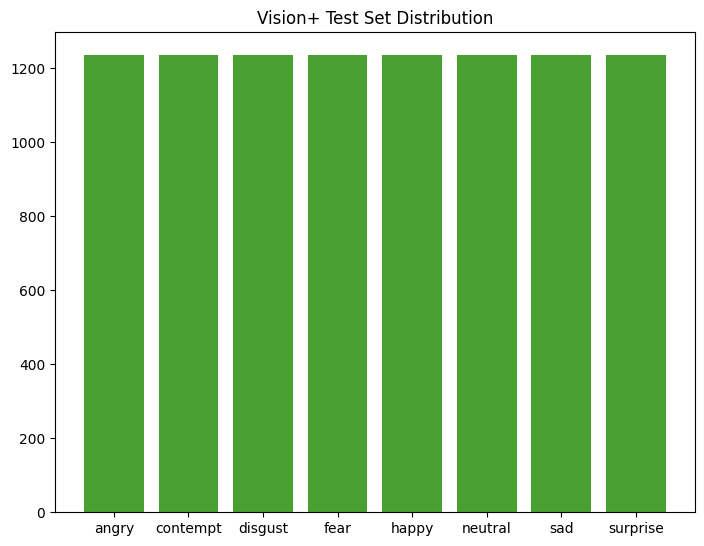

In [83]:
plot_dataset(data_vision[0], "Vision+ Test Set Distribution")

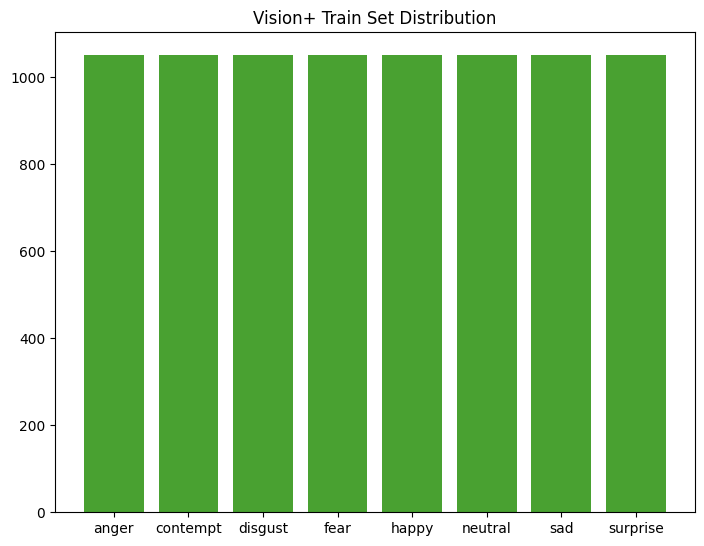

In [84]:
data_vision
plot_dataset(data_vision[2], "Vision+ Train Set Distribution")

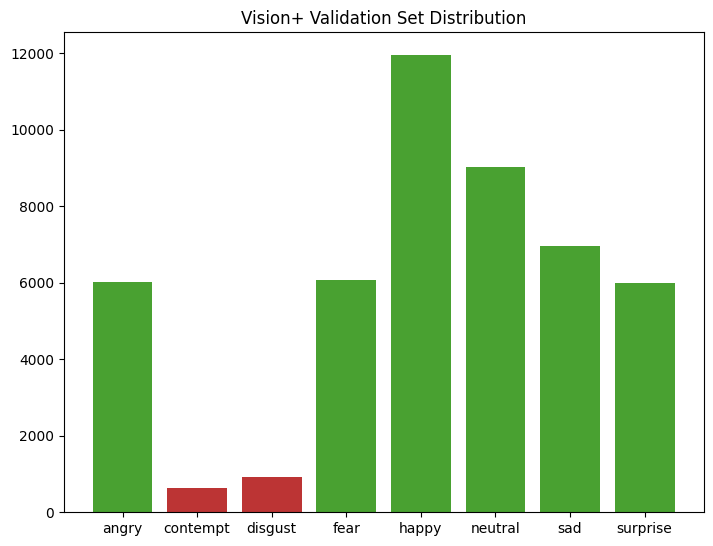

In [86]:
plot_dataset(data_vision[1], "Vision+ Validation Set Distribution")

### Balance All classes to the maximum

In [138]:
basedir = "./Vision+/"
types = ['val', 'test', 'train']
ref = [str(basedir  + types[i] + "/*") for i in range(len(types))]
total = 0
for el in ref:
  total += iw.counter_samples(el)
print(total)

65910


In [139]:
#Number of datapoints per class in training dataset
train=ref[2]
countcl_tr = iw.counter_samples_on_class(train)
print(f"Training dataset countclass: {countcl_tr}")

Training dataset countclass: {'angry': 6019, 'contempt': 638, 'disgust': 914, 'fear': 6085, 'happy': 11953, 'neutral': 9037, 'sad': 6965, 'surprise': 6003}


In [140]:
val=ref[0]
#Number of datapoints per class in validation dataset
countcl_val = iw.counter_samples_on_class(val)
print(f"Training dataset countclass: {countcl_val}")

Training dataset countclass: {'angry': 1051, 'contempt': 1051, 'disgust': 1051, 'fear': 1051, 'happy': 1051, 'neutral': 1051, 'sad': 1051, 'surprise': 1051}


In [141]:
test=ref[1]
#Number of datapoints per class in test dataset
countcl_ts = iw.counter_samples_on_class(test)
print(f"Training dataset countclass: {countcl_ts}")

Training dataset countclass: {'angry': 1236, 'contempt': 1236, 'disgust': 1236, 'fear': 1236, 'happy': 1236, 'neutral': 1236, 'sad': 1236, 'surprise': 1236}


####  Check max and min class in the Training Dataset

In [142]:
# validation balancing.
min = sys.maxsize
max = 0

for el in countcl_tr.keys():
  if countcl_tr[el] < min:
    min = countcl_tr[el]
  elif countcl_tr[el] > max:
    max = countcl_tr[el]

In [143]:
added_datapoints= max*8 - iw.counter_samples(train)
actual_datapoints = total
augmented_dataset = actual_datapoints + added_datapoints
actual_test_datapoints = iw.counter_samples(test)
actual_val_datapoints = iw.counter_samples(val)

In [144]:
print(f"This supposes an augmentation of {added_datapoints/actual_datapoints *100}%")
print(f"After the agumentation the new proportions would be:")
print(f"Test_proportion: {actual_test_datapoints/augmented_dataset *100}%")
print(f"Validation_proportion: {actual_val_datapoints/augmented_dataset *100}%")

This supposes an augmentation of 72.84175390684267%
After the agumentation the new proportions would be:
Test_proportion: 8.679775280898877%
Validation_proportion: 7.38061797752809%


#### Datapoints that have to be added per class


In [145]:
generated = {key: max-value  for key, value in countcl_tr.items()}
print(f"The amount that needs to be generated per class:{generated}")

The amount that needs to be generated per class:{'angry': 5934, 'contempt': 11315, 'disgust': 11039, 'fear': 5868, 'happy': 0, 'neutral': 2916, 'sad': 4988, 'surprise': 5950}


#### The new datapoints will be generated in proportion to the existing datapoints

In [149]:
prop_gen={}
for cl in generated.keys():
    tot = countcl_tr[cl] + countcl_val[cl] + countcl_ts[cl]
    #Amount of datapoints of class cs that will be generated from the train/test/val/dataset
    prop_train =  countcl_tr[cl]/tot * generated[cl]
    prop_val = countcl_val[cl]/tot *generated[cl]
    prop_test = countcl_ts[cl]/tot *generated[cl]
    
    prop_gen[cl]= [int(prop_train),int(prop_val),int(prop_test)]
print(f"The amount of samples per class that will be augmented per set:")
print(prop_gen)

The amount of samples per class that will be augmented per set:
{'angry': [4300, 750, 883], 'contempt': [2468, 4065, 4781], 'disgust': [3152, 3624, 4262], 'fear': [4265, 736, 866], 'happy': [0, 0, 0], 'neutral': [2327, 270, 318], 'sad': [3755, 566, 666], 'surprise': [4308, 754, 887]}


In [163]:
def generator(path,
              format_img, 
              dest_path, 
              starting_counter=0, 
              num_augment=1, zoom_range=0.4, 
              brightness_range=(0.6,0.8), 
              width_shift_range=0.1, 
              height_shift_range=0.1, 
              rotation_range=10):
    # generator declaration.
    gen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        brightness_range=brightness_range,
        zoom_range=zoom_range,
        horizontal_flip=True
    )
    print(f'Data Augmentation parameters:\nZoom Range: {zoom_range}\nBrightness Range: {brightness_range}\nShift: ({width_shift_range},{height_shift_range})\nRotation Degrees: {rotation_range}')
   
    # make destination directory in case it doesn't exist.
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
   
    # Image Processing
    files = glob.glob(path + "/*." + format_img)
    num_files = len(files)
    base_augment = num_augment // num_files
    extra_augment = num_augment % num_files
    
    print('Starting generation...')
    c = starting_counter
    for i, file in enumerate(files):
        img = cv2.imread(file)
        # convert to numpy array.
        samples = np.expand_dims(img, 0)
        iterator = gen.flow(samples, batch_size=1)
        # Apply one extra augmentation to the first 'extra_augment' images
        total_augments = base_augment + (1 if i < extra_augment else 0)
        for j in range(total_augments):
            batch = iterator.next()
            image = batch[0].astype('uint8')
            cv2.imwrite(os.path.join(dest_path, f"augmented_on_{c}.{format_img}"), image)
            c += 1
    
    print(f'Data Augmentation for {path} is done!')



In [164]:
source_path= "./Vision+/val/borrar/"
destination_path = "./Vision+/tmp/angry/"
format_img='jpg'
generator(source_path,format_img,destination_path,num_augment=5)

Data Augmentation parameters:
Zoom Range: 0.4
Brightness Range: (0.6, 0.8)
Shift: (0.1,0.1)
Rotation Degrees: 10
Starting generation...
Data Augmentation for ./Vision+/val/borrar/ is done!


In [ ]:
# utilities variables.
augm_class = []
copies = {}

# counters of samples in each class of the training set. 
categories_data = iw.counter_samples_on_class("/content/drive/MyDrive/Datasets/AVFER/train/*")

# defines the number of copies weighted to the current amount of data of the class samples.
for cl in categories_data.keys():
  copies[cl] = int(20000/categories_data[cl]) + 1

In [ ]:
%%time

# applying weighted data augmentation.
for class_ in categories_data.keys():
  print('Generation of {} samples with {} copy...'.format(class_, copies[class_]))
  generator("/content/drive/MyDrive/Datasets/AVFER/train/" + class_, "jpg", "/content/drive/MyDrive/Datasets/AVFER/train/" + class_ + "/", 0, num_augment=copies[class_])

In [ ]:
# making of the result and augmented dataset version. VFER is the augmented version of AVFER.
!rm -rf /content/drive/MyDrive/Datasets/VFER/
!mkdir /content/drive/MyDrive/Datasets/VFER/
!mkdir /content/drive/MyDrive/Datasets/VFER/train
!mkdir /content/drive/MyDrive/Datasets/VFER/val
!mkdir /content/drive/MyDrive/Datasets/VFER/test

In [ ]:
# creates subfolders for VFER.
base_dir = "/content/drive/MyDrive/Datasets/VFER/"
x = "/content/drive/MyDrive/Datasets/AffectNet/train_class/"
subfolders = [el for el in os.listdir(base_dir)]
classes = [cl for cl in os.listdir(x)]
for cl in classes:
  for folder in subfolders:
    os.mkdir(base_dir  + folder + "/" + cl)

In [ ]:
# dump balanced dataset to VFER from AVFER samples.
source_folder = r"/content/drive/MyDrive/Datasets/AVFER/"
destination_folder = r"/content/drive/MyDrive/Datasets/VFER/"
cap_class = 20000
print('Start dataset copying...')
print('-'*40)
# fetch all files.
for subfolder in os.listdir(source_folder):
  if subfolder == ".ipynb_checkpoints":
      print('Passing checkpoint files')
      continue
  print("Going in the subfolder {}".format(subfolder))
  for cl in os.listdir(source_folder + subfolder + "/"):
    print("Going in the class {}/{}".format(subfolder, cl))
    if cl == ".ipynb_checkpoints":
      print('Passing checkpoint files')
      continue
    else:
      counter_file = 0
      for file_name in glob.glob(source_folder  + subfolder + "/" + cl + "/*.jpg"):
        # construct full file path.
        source = source_folder + subfolder + "/" + cl + "/" + os.path.basename(file_name)
        destination = destination_folder + subfolder + "/" + cl + "/" + os.path.basename(file_name)
        # copy only files.
        if os.path.isfile(source) and counter_file < cap_class:
          counter_file += 1
          shutil.copy(source, destination)
        if counter_file > cap_class:
          break
  
      print('Copied on {}'.format(cl))
print('-'*40)
print('Dump done.')

In [ ]:
# plot final training set.
plot_dataset("/content/drive/MyDrive/Datasets/VFER/train/*")

In [ ]:
# plot final validation set.
plot_dataset("/content/drive/MyDrive/Datasets/VFER/val/*")

In [ ]:
# plot final testing set.
plot_dataset("/content/drive/MyDrive/Datasets/VFER/test/*")